# This Notebook Presents Results and Visualizations for SAE based on MF architecture

In [ ]:
from typing import Callable, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from pathlib import Path
from torch.utils.data import DataLoader
export_dir = os.getcwd()
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot
import random
import math
import heapq
from scipy.special import expit  # Sigmoid function
import itertools
from IPython.display import Latex, display
import pickle
from scipy.stats import kendalltau

import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Set to None to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

test_flag = 1

In [ ]:
pip install ipynb

In [ ]:
from ipynb.fs.defs.utils import *
from ipynb.fs.defs.data_processing import *
from ipynb.fs.defs.models import *
from ipynb.fs.defs.training import *

# General Data

## Model Data

In [ ]:
# Load the dataset from the .csv file
# df = pd.read_csv(Path(export_dir,'interaction_embeddings.csv')) # based on the training dataset only
df_item_emb = pd.read_csv(Path(export_dir,'res_csv/ML1M/mf/items_embeddings_mf_model.csv'))
df_user_emb = pd.read_csv(Path(export_dir,'res_csv/ML1M/mf/users_embeddings_mf_model.csv'))
df_b_i_emb = pd.read_csv(Path(export_dir,'res_csv/ML1M/mf/b_i_mf_model.csv'))
df_b_u_emb = pd.read_csv(Path(export_dir,'res_csv/ML1M/mf/b_u_mf_model.csv'))


# CONVERT TO TENSORS
dataset_items = torch.tensor(df_item_emb.values, dtype=torch.float32)
dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)
dataset_bu = torch.tensor(df_b_u_emb.values, dtype=torch.float32)
dataset_bi = torch.tensor(df_b_i_emb.values, dtype=torch.float32)


interaction_embeddings = dataset_users #[:, 2:]



df_item_emb1 = df_item_emb.copy()
df_item_emb1.index = ratings_matrix.columns

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(df_item_emb)
df_cosine_sim_matrix = pd.DataFrame(cosine_sim_matrix)
df_cosine_sim_matrix

# General data analysis:

## Separation into train and test sets:


In [ ]:
test_subset_users = random.sample(list(df_user_emb.index), k=math.floor(df_user_emb.shape[0]*0.2))
test_subset_items = random.sample(list(df_item_emb.index), k=math.floor(df_item_emb.shape[0]*0.2))

In [ ]:
train_subset_users = [i for i in df_user_emb.index if i not in test_subset_users]

interaction_embeddings = dataset_users[train_subset_users]


# loading the model

In [ ]:
model_name = 'ml1m_SAE_MF_model'
# Initialize a new model instance with the same architecture
autoencoder = torch.load(Path(export_dir,f'models/ML1M/{model_name}.pth'), weights_only  = False)

# test_subset = autoencoder.test_subset_ind
test_subset_users = autoencoder.test_subset_users_ind
test_subset_items = autoencoder.test_subset_items_ind


train_subset_users = [i for i in df_user_emb.index if i not in test_subset_users]

interaction_embeddings=dataset_users[train_subset_users]


In [ ]:
latents_pre_act_items, latents_items, reconstructions_items = autoencoder(dataset_items)

In [ ]:
latents_pre_act_users, latents_users, reconstructions_users = autoencoder(dataset_users)

#sparsity check

In [ ]:
print((latents_items == 0).sum().item())
print((latents_items!=0).sum().item())

# dataset_items = normalize_matrix(torch.Tensor(dataset_items))
# dataset_items = pad_or_truncate_tensor(dataset_items, 20)
latents_pre_act_single, latents_single, _ = autoencoder(np.array(dataset_items))

print(np.array((latents_single == 0).sum(axis=1)).mean()) # sums up over columns for each column- item
print(np.array((latents_single != 0).sum(axis=1)).mean())

61586
19946
16.617916891527255
5.382083108472747


# Latent Representation Analysis

# Related to items:

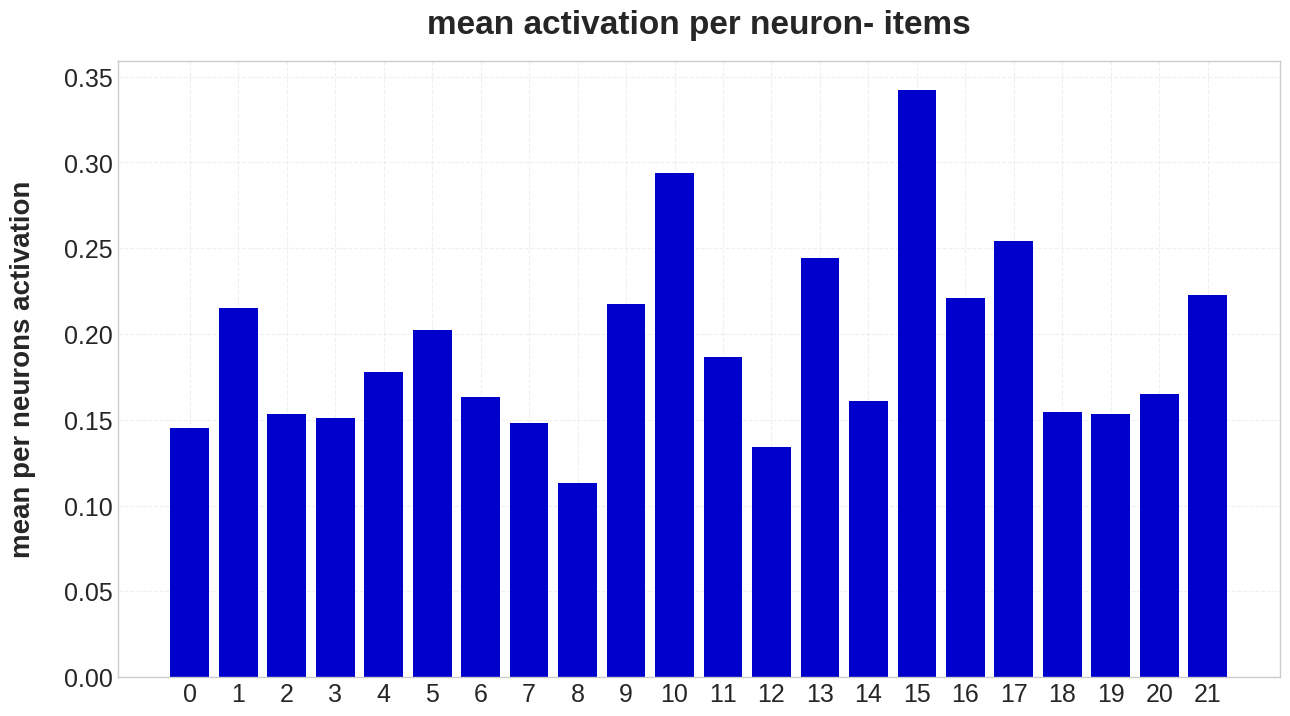

In [ ]:
# averaged activation on every neuron:
plt.style.use('seaborn-v0_8-whitegrid')

latents_items_numpy_array = latents_items.detach().numpy()
latents_items_df = pd.DataFrame(latents_items_numpy_array)
latents_items_df.index = ratings_matrix.columns

# latents_df.mean()

plt.figure(figsize=(15, 8))
plt.bar(latents_items_df.columns, latents_items_df.mean(), color='mediumblue')
# plt.title(f'mean activation per neuron- {model_name}- items', pad=20,weight='bold',fontsize=24)
plt.title(f'mean activation per neuron- items', pad=20,weight='bold',fontsize=24)
# plt.xlabel('Neurons', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('mean per neurons activation', labelpad=20,weight='bold',fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xticks(latents_items_df.columns,fontsize=18)
plt.yticks(fontsize=18)

# plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
plt.show()



In [ ]:
latents_pre_act_usr, latents_usr, reconstructions_usr = autoencoder(interaction_embeddings)


latents_numpy_array_usr = latents_usr.detach().numpy()
latents_df_usr = pd.DataFrame(latents_numpy_array_usr)
latents_df_usr.index = df_user_emb.index[train_subset_users]

In [ ]:
ms_score_new(df_cosine_sim_matrix, latents_items)

## back to all the users dataset:

In [ ]:
# dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)
# dataset_users1 = normalize_matrix(dataset_users)
# dataset_users1 = pad_or_truncate_tensor(dataset_users1, 20)
latents_pre_act_all_usr, latents_all_usr, reconstructions_all_usr = autoencoder(dataset_users)

latents_numpy_array_all_usr = latents_all_usr.detach().numpy()
latents_df_all_usr = pd.DataFrame(latents_numpy_array_all_usr)
latents_df_all_usr.index = df_user_emb.index

# Latent activation Visualizations

In [ ]:
curr_female_ind = np.where(df_usr['gender']==1)
curr_df_gender_f = latents_df_all_usr.iloc[curr_female_ind[0],:]
curr_male_ind = np.where(df_usr['gender']==0)
curr_df_gender_m = latents_df_all_usr.iloc[curr_male_ind[0],:]
comparison = pd.concat([curr_df_gender_f.mean(), curr_df_gender_m.mean()],axis=1)


# Calculate mean activation per neuron for documentary movies
mean_activation_f = curr_df_gender_f.mean()
normalized_mean_activation_f = mean_activation_f / latents_df_all_usr.mean()
mean_activation_m = curr_df_gender_m.mean()
normalized_mean_activation_m = mean_activation_m / latents_df_all_usr.iloc[train_subset_users,:].mean()

diff=(normalized_mean_activation_f-normalized_mean_activation_m)

# diff[20] = 1.1
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(16, 8))
plt.bar(latents_df_all_usr.columns, diff, color='tan', width=0.7)
# plt.title(f'Diff mean activation between male and female', pad=20,weight='bold',fontsize=24)
plt.title(f'Mean Activation Difference: Women vs. Men', pad=20,weight='bold',fontsize=24)
# plt.xlabel('Neuron', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Activation Level Difference', labelpad=20,weight='bold',fontsize=20)
plt.xticks(latents_df_all_usr.columns,rotation=90,fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
score_low = {}
score_high = {}

numerator_age = []
ages= [1, 18, 25,35,45, 50, 56]
ages_list = ['1','18','25','35','45','50','56']
for age in ages:
  numerator_age_ids = [i for i in np.where(df_usr.iloc[:,2]== age)[0]]
  numerator_age.append(len(numerator_age_ids))


ind = 0
for age in ages:

  curr_age_ind = np.where(df_usr['age']==int(age))
  curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
  if ind ==1:
      prev_df_age = curr_df_age.copy()

      curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
      comparison_age = pd.concat([prev_df_age.mean(), curr_df_age.mean()],axis=1)
  elif ind > 1:

      curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
      comparison_age = pd.concat([comparison_age ,curr_df_age.mean()],axis=1)
  else:

      curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]




  mean_activation = curr_df_age.mean()

  normalized_mean_activation = mean_activation / latents_df_all_usr.mean()
  if int(age) == 1:
    normalized_mean_activation_0 = normalized_mean_activation

  ind+=1


comparison_age.columns = ages_list

In [ ]:
curr_age_ind = np.where(df_usr['age']!='1')
curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
mean_activation = curr_df_age.mean()
normalized_mean_activation_adult = mean_activation / latents_df_all_usr.mean()


plt.figure(figsize=(10, 7))
plt.bar(latents_df_all_usr.columns, normalized_mean_activation_0, color='tan', width=0.7)
# plt.title(f'Diff mean activation between male and female', pad=20,weight='bold',fontsize=24)
plt.title(f'Mean Activation : young age- under 18', pad=20,weight='bold',fontsize=24)
# plt.xlabel('Neuron', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Neuron Activation Level', labelpad=20,weight='bold',fontsize=20)
plt.xticks(latents_df_all_usr.columns,fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
diff = normalized_mean_activation_0-normalized_mean_activation_adult

plt.figure(figsize=(16, 8))
plt.bar(latents_df_all_usr.columns, diff, color='tan', width=0.7)
# plt.title(f'Diff mean activation between male and female', pad=20,weight='bold',fontsize=24)
plt.title(f'Mean Activation Difference: young vs. adult', pad=20,weight='bold',fontsize=24)
# plt.xlabel('Neuron', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Activation Level Difference', labelpad=20,weight='bold',fontsize=20)
plt.xticks(latents_df_all_usr.columns,fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
keys_genres = list(genre_id.keys())


for ind, genre in enumerate(all_genres):

  curr_genre_ind = list(genre_id[(keys_genres[ind])])
  if ind ==1:
      prev_df_genre = curr_df_genre.copy()

      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([prev_df_genre.mean(), curr_df_genre.mean()],axis=1)
  elif ind > 1:

      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([comparison ,curr_df_genre.mean()],axis=1)
  else:

      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]



  fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))


  # Calculate mean activation per neuron for documentary movies
  mean_activation = curr_df_genre.mean()

  # Mean activation per neuron
  ax1.bar(latents_items_df.columns, mean_activation, color='tan', width=0.6)
  ax1.bar(latents_items_df.columns+0.1, latents_items_df.mean(), color='mediumblue',width=0.1)


  ax1.set_title(f'Mean Activation per Neuron - {genre} Movies', pad=20,weight='bold',fontsize=24)
  ax1.set_xlabel('Neurons', labelpad=20,weight='bold',fontsize=20)
  ax1.set_ylabel('Mean Neuron Activation', labelpad=20,weight='bold',fontsize=20)
  ax1.grid(True, linestyle='--', alpha=0.5)
  ax1.set_xticks(range(len(latents_items_df.columns)))
  ax1.set_xticklabels(latents_items_df.columns,fontsize=18)
  # ax1.tick_params(axis='y', labelsize=14)
  ax1.tick_params(axis='both', which='major', labelsize=18)
  #ax1.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

  leg = ax1.legend([f'Mean neuron activation\nacrosss {genre} movies','Mean neuron activation\nacrosss all items'], loc='upper right', fontsize=16, fancybox=False,frameon=True)
  if ind == 1 or ind == 2 or ind== 3 or ind == 13:
      leg = ax1.legend([f'Mean neuron activation\nacrosss {genre} movies','Mean neuron activation\nacrosss all items'], loc='upper right', fontsize=16, fancybox=False,frameon=True)
  # Access the legend frame and set its edge color and linewidth
  frame = leg.get_frame()
  frame.set_edgecolor('grey')
  frame.set_linewidth(2)


comparison.columns = all_genres


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'grey'
for index in comparison.index:

  # plt.show()
  plt.figure(figsize=(16, 8))
  r = plt.bar(all_genres, round(comparison.iloc[index,:],2), color='tan', width=0.6, edgecolor = 'darkgoldenrod', hatch = '//')
  plt.bar_label(r,fontsize=14)
  # plt.bar(all_genres, comparison.iloc[index, :], color='tan', width=0.6)
  plt.title(f'Neuron {index} - Mean Activation over Different Genres', pad=20, weight='bold', fontsize=24)
  plt.xlabel('Genres', labelpad=20, weight='bold', fontsize=20)
  plt.ylabel('Mean Activation Level', labelpad=20, weight='bold', fontsize=20)
  plt.xticks(rotation=90, fontsize=18)
  plt.yticks(fontsize=18)
  plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw=2.5)

  leg = plt.legend([f'Mean neuron {index} activation\nacross all items'], loc='upper right', fontsize=16, fancybox=False)
  if index == 16 or index== 0 or index==1 or index==8 or index==9 or index== 18 or index== 21 or index== 14:
    leg = plt.legend([f'Mean neuron {index} activation\nacross all items'], loc='upper left', fontsize=16, fancybox=False)
  # Access the legend frame and set its edge color and linewidth
  frame = leg.get_frame()
  frame.set_edgecolor('grey')
  frame.set_linewidth(2)

  plt.grid(True, linestyle='--', alpha=0.5)
  plt.show()

# Division to genres

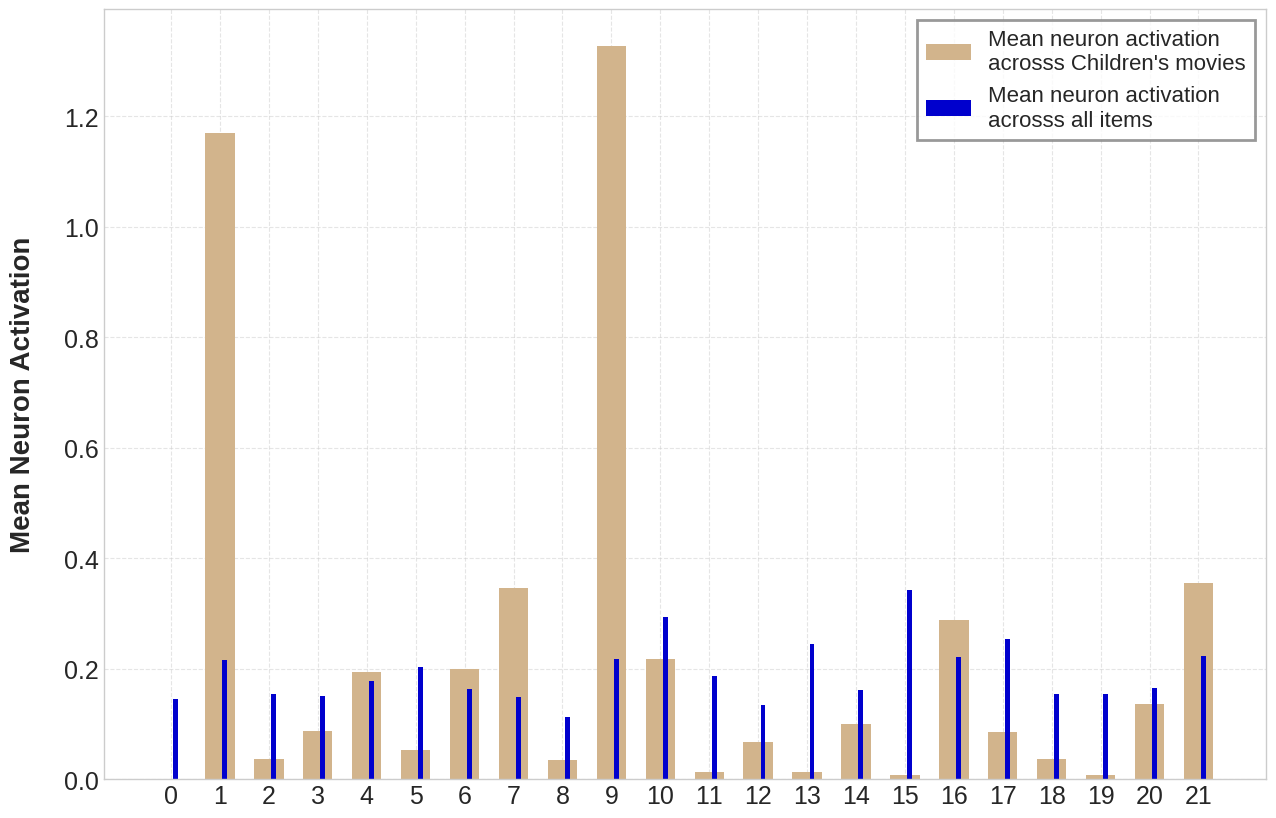

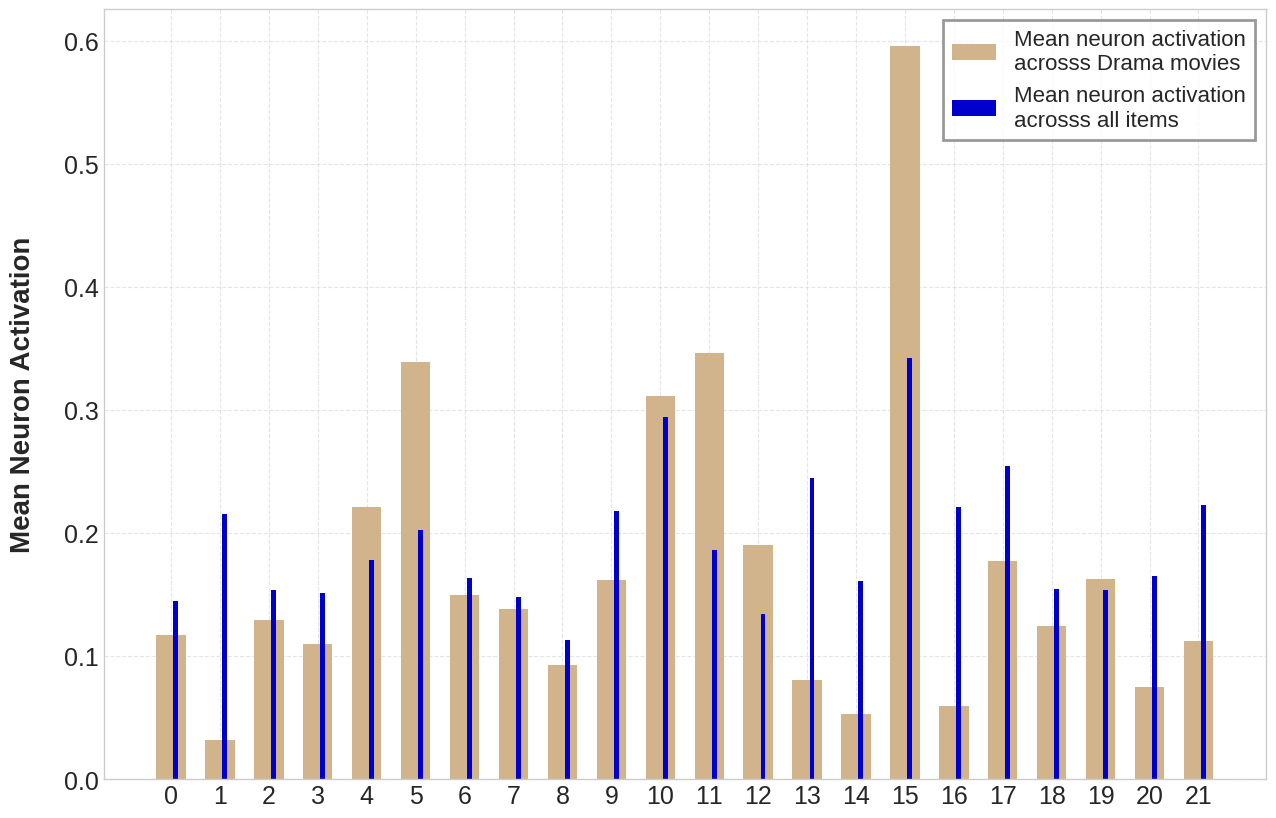

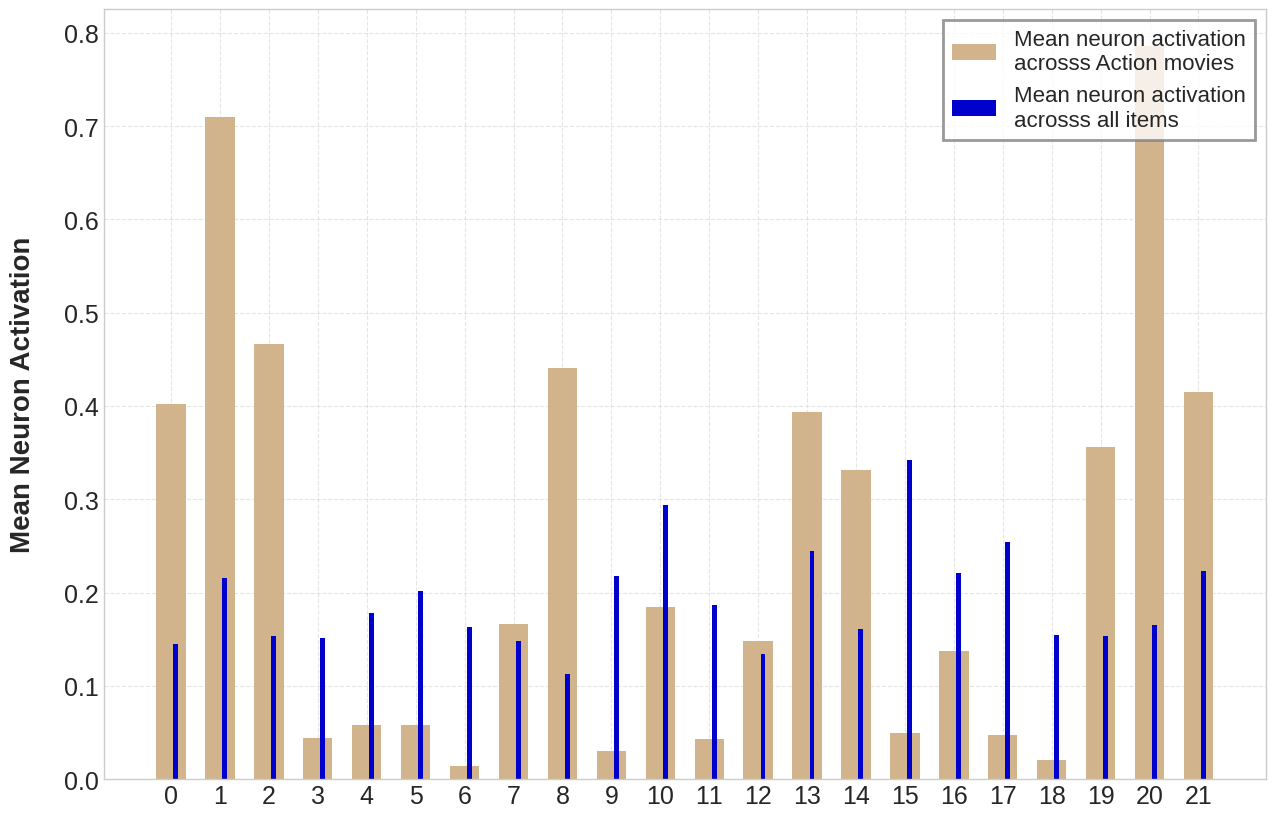

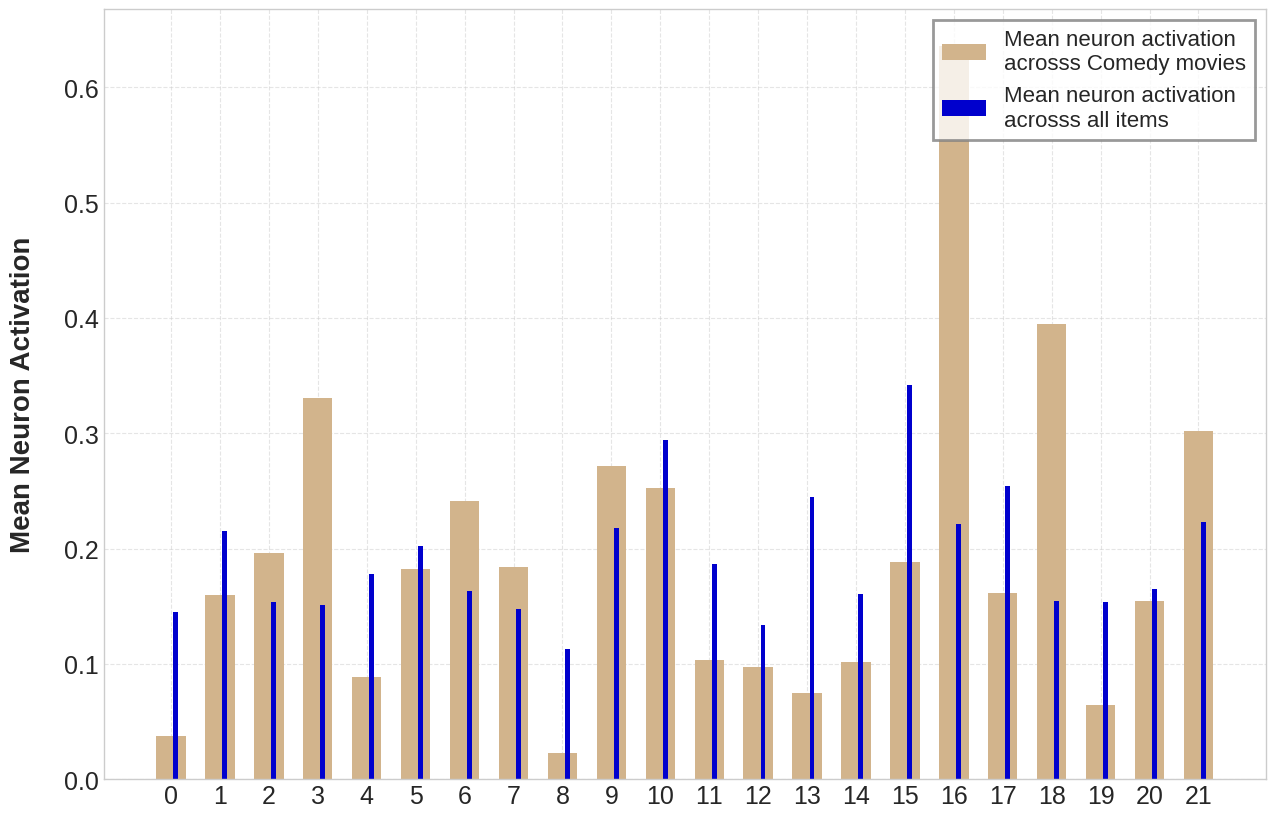

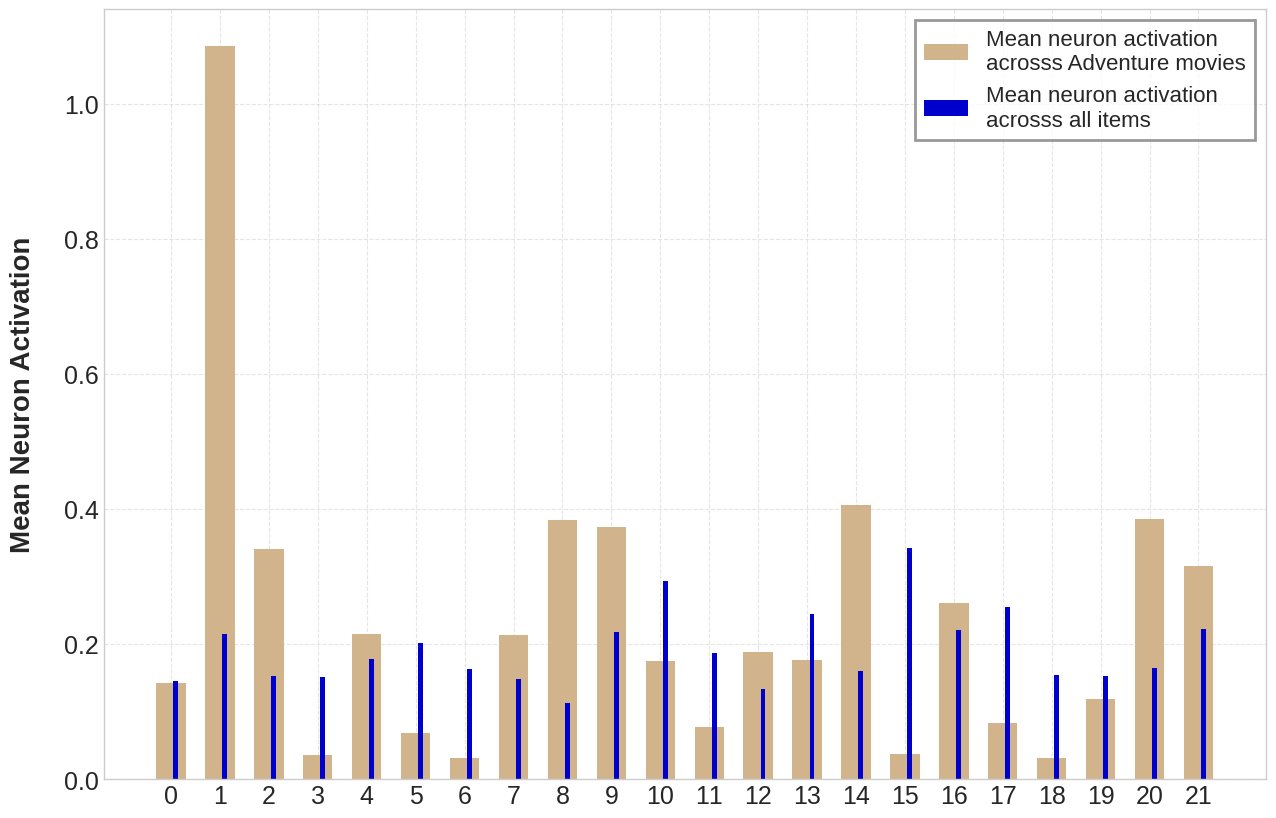

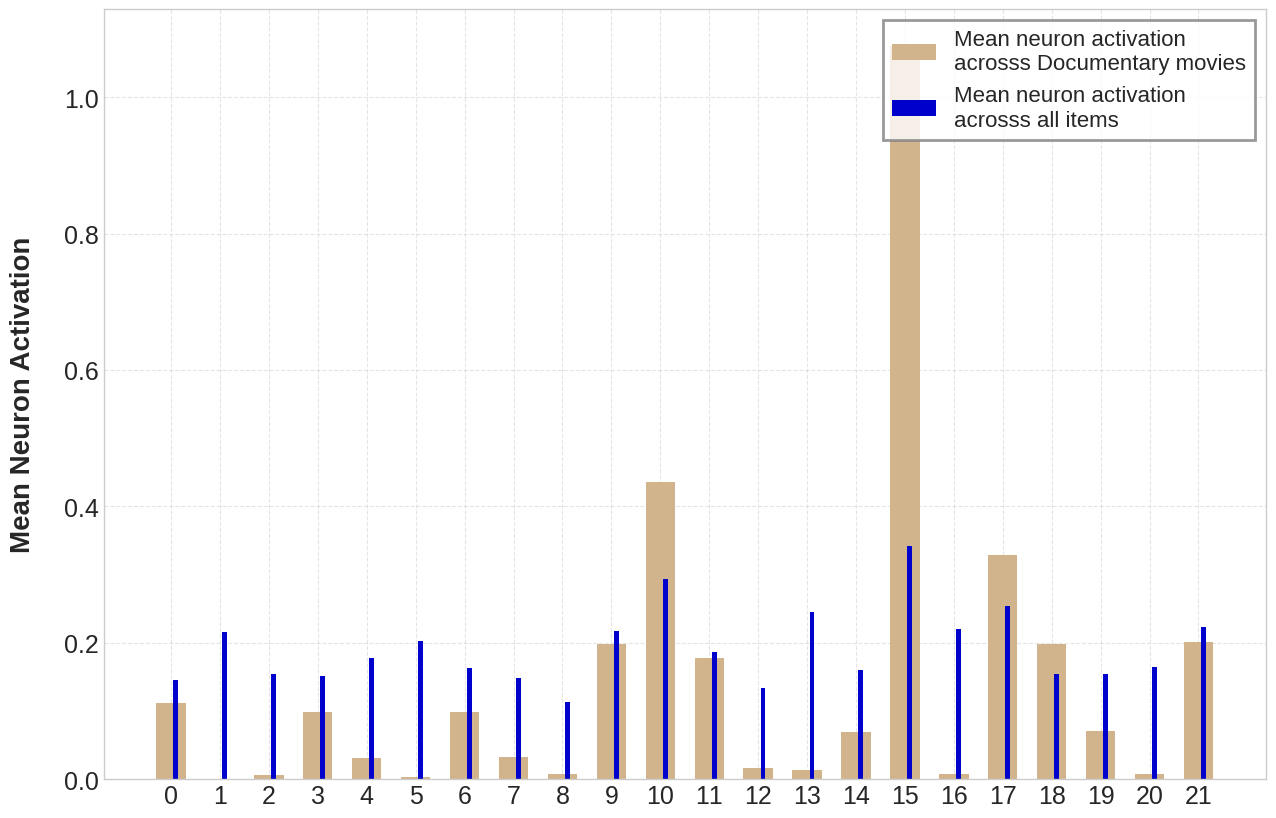

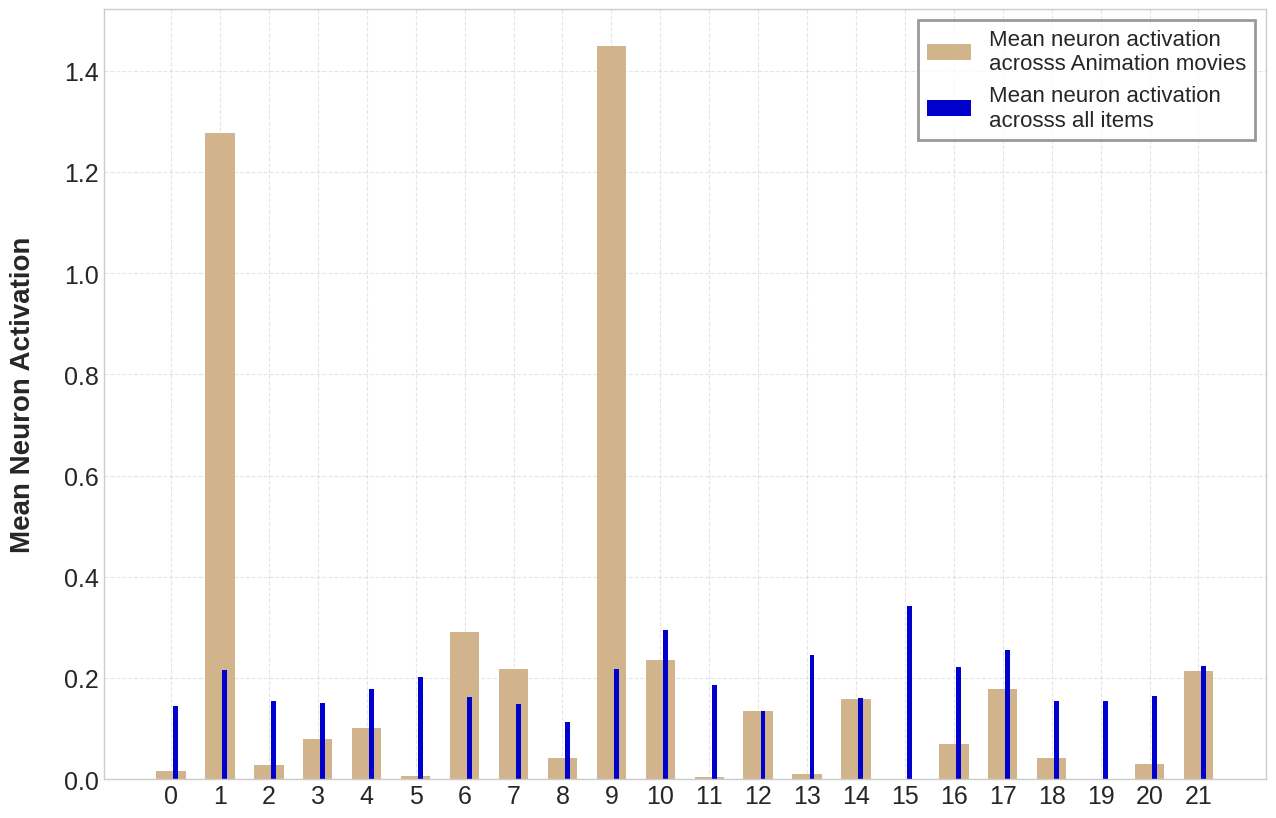

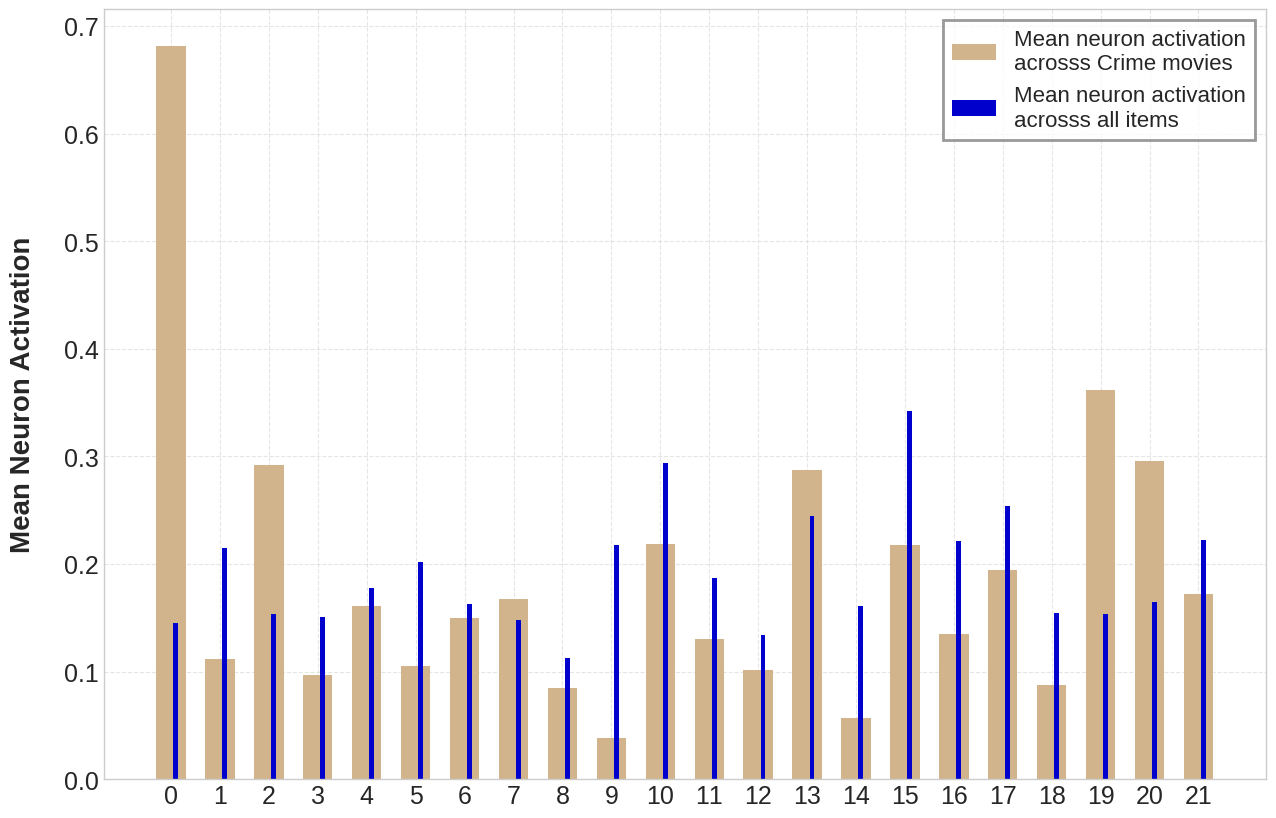

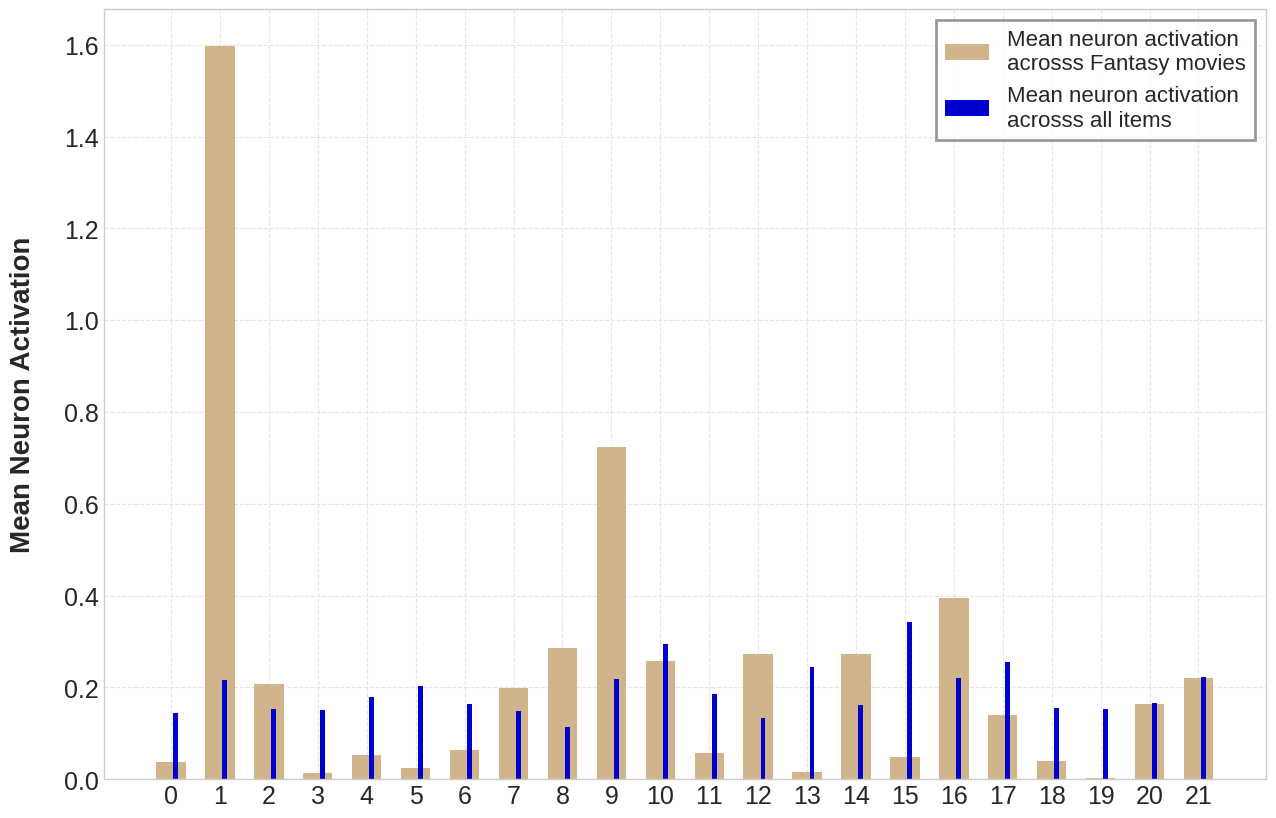

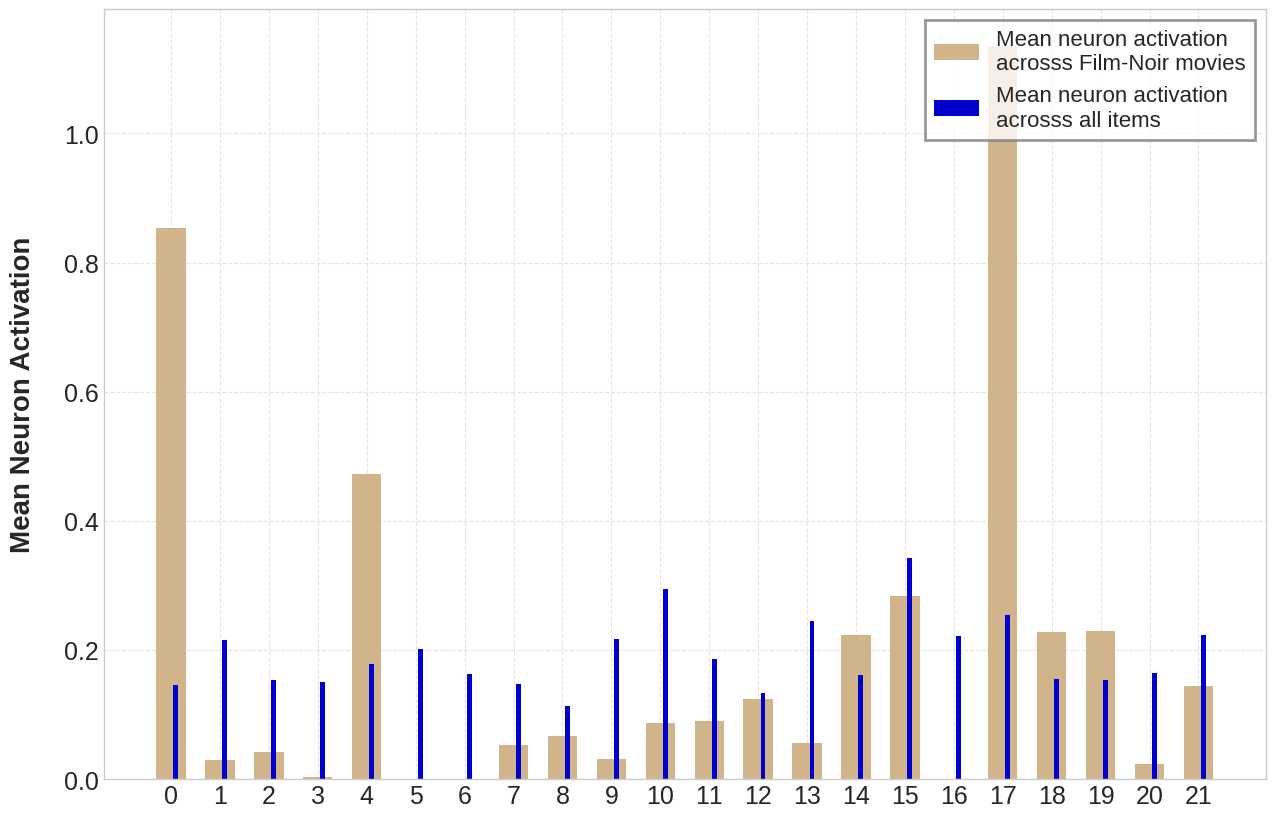

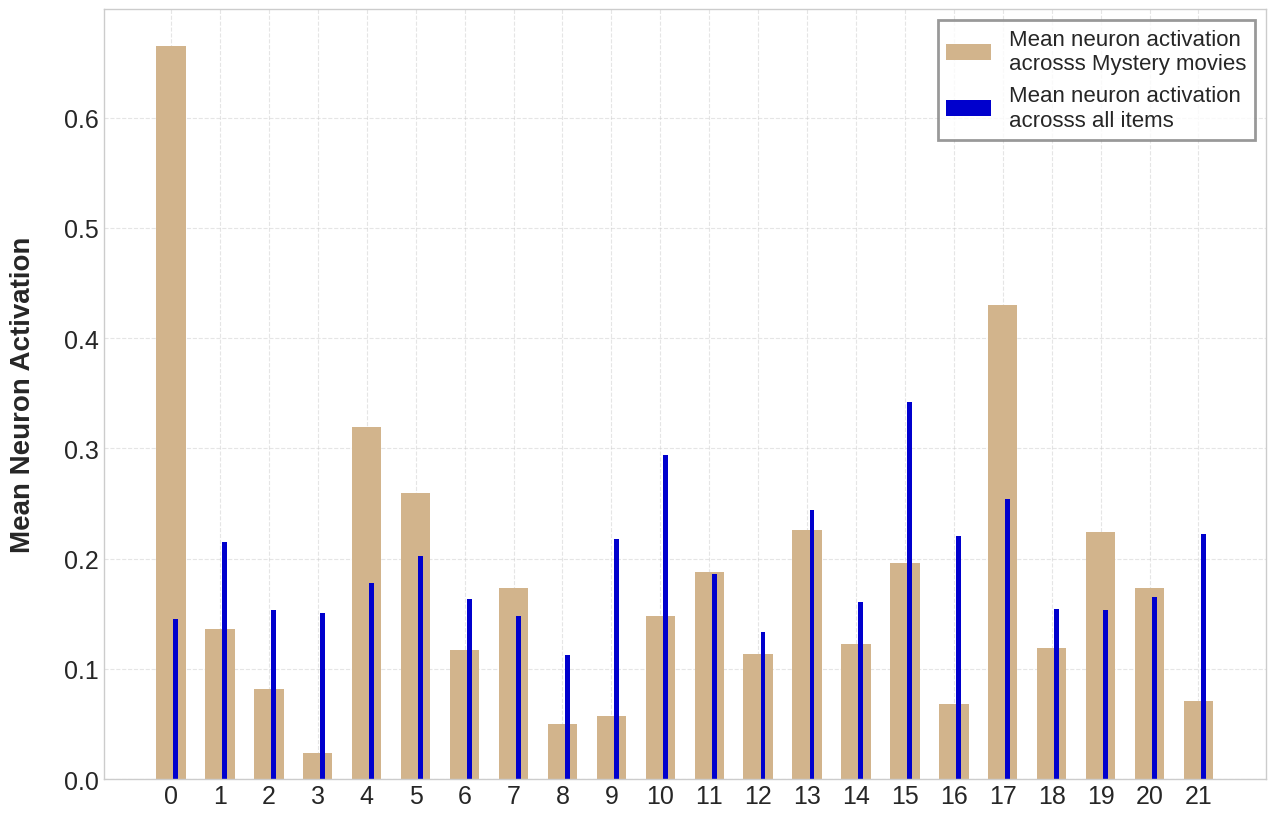

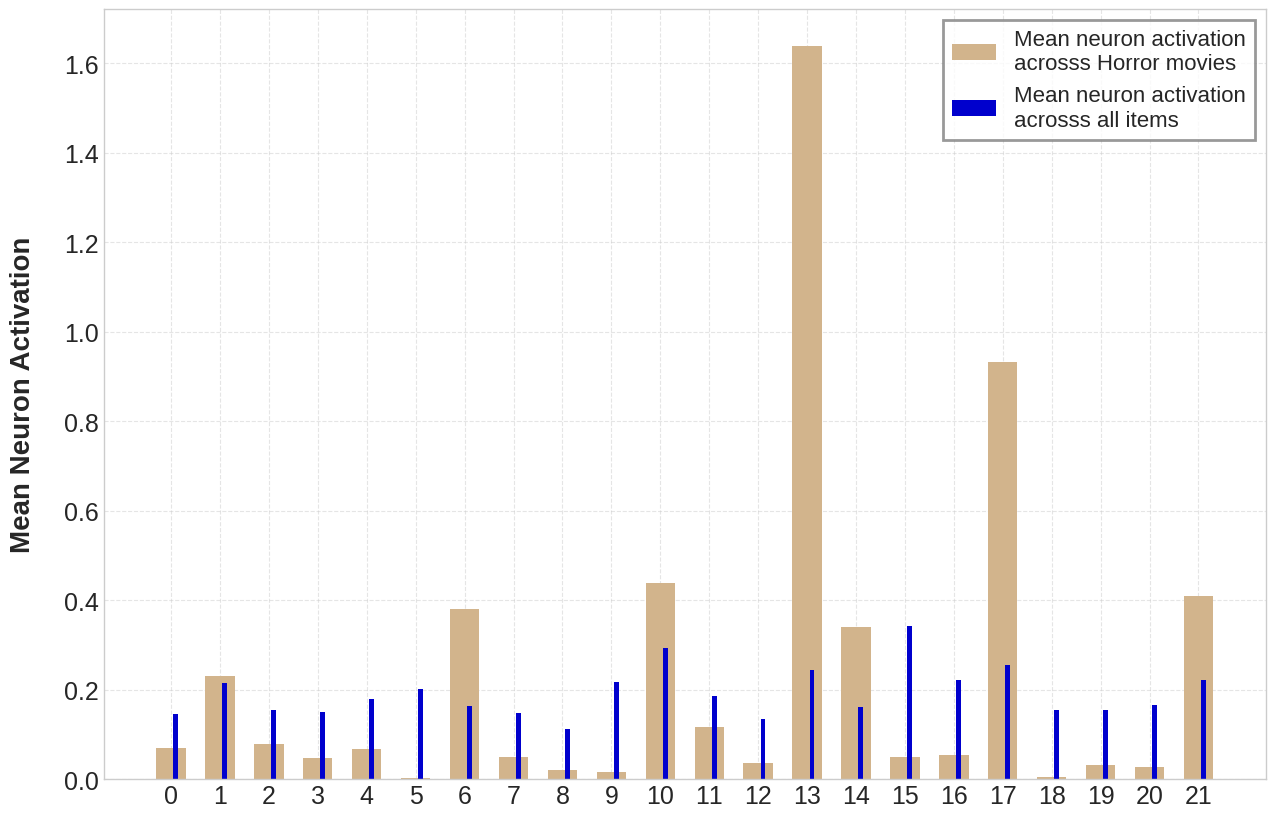

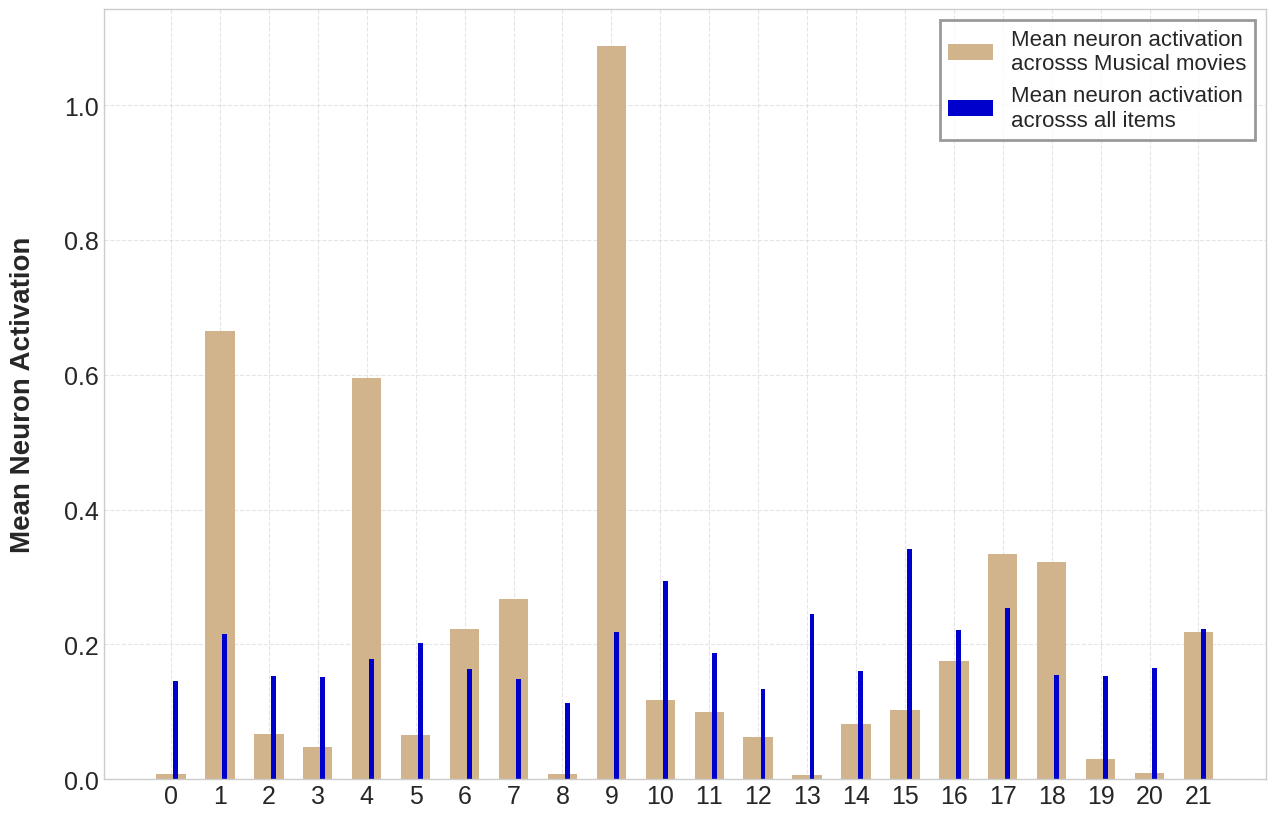

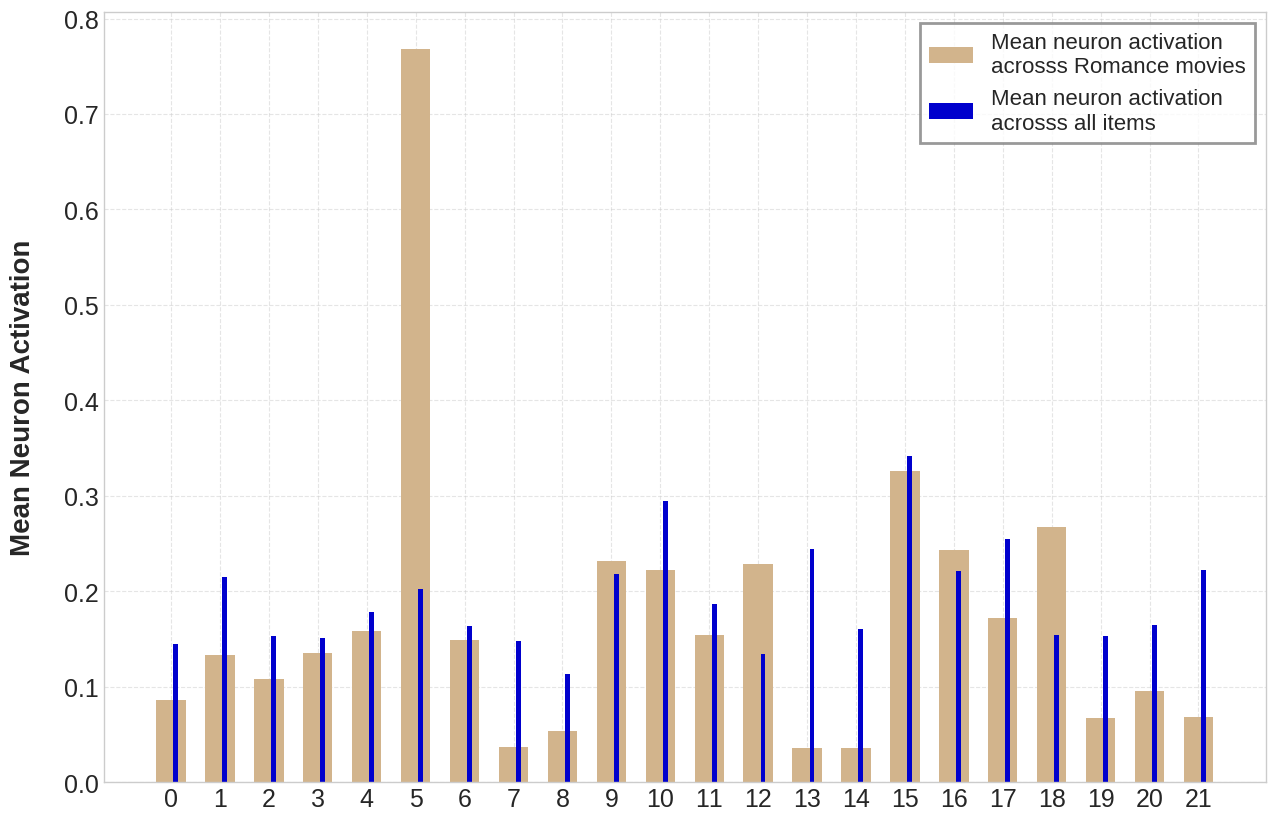

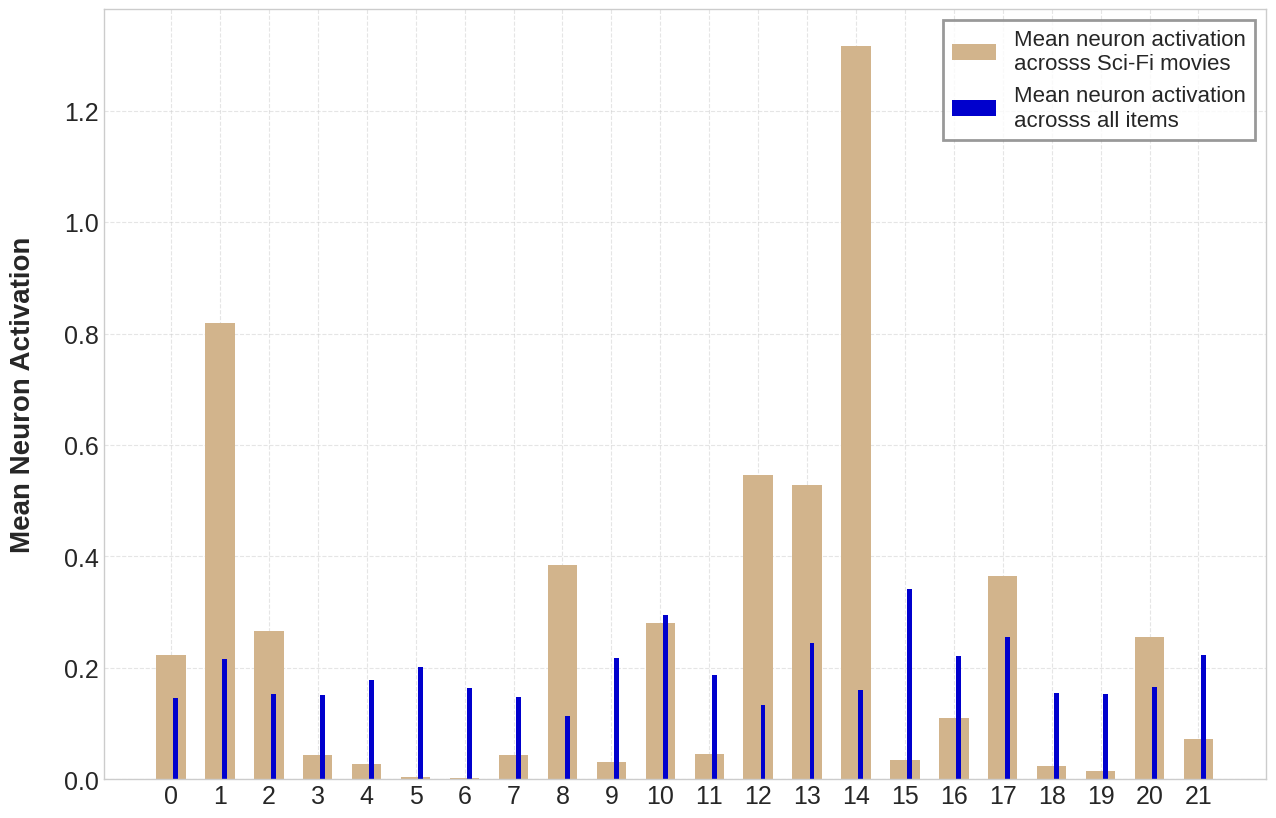

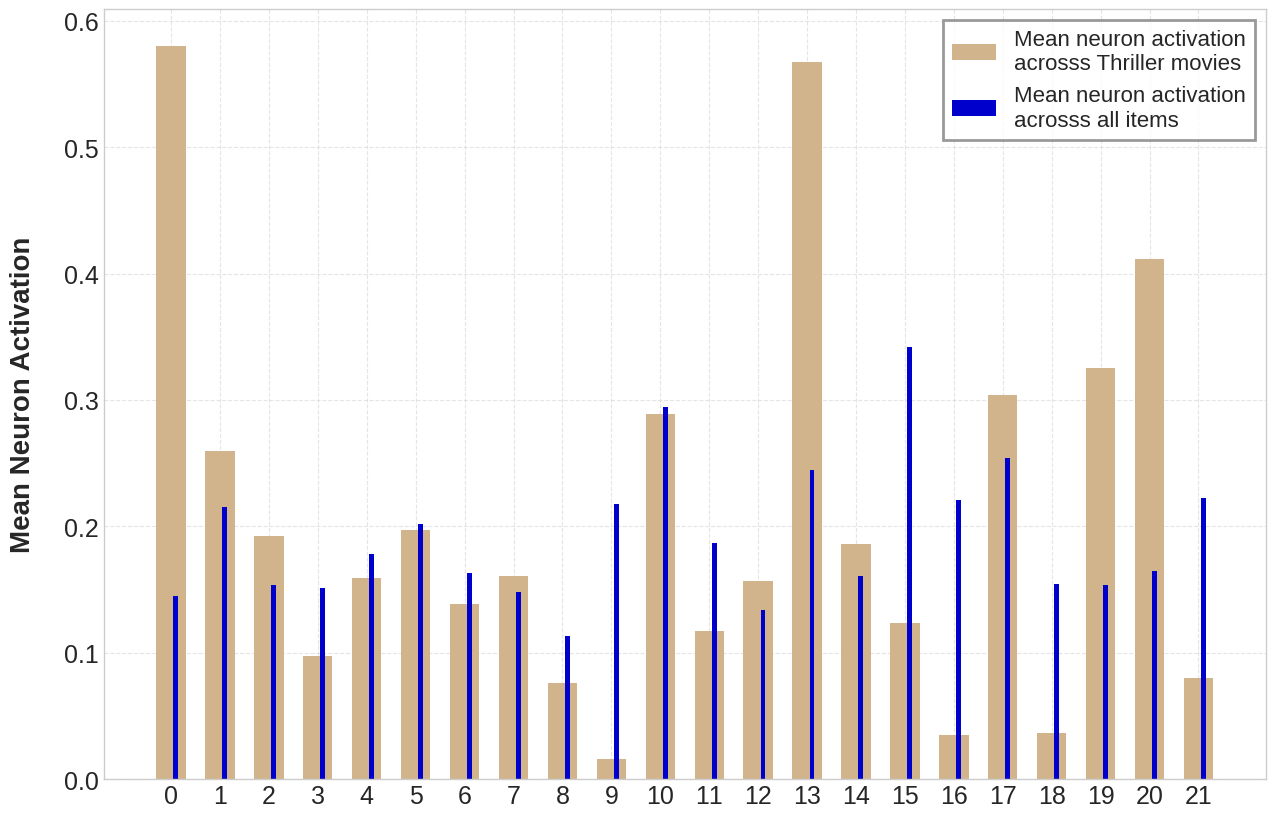

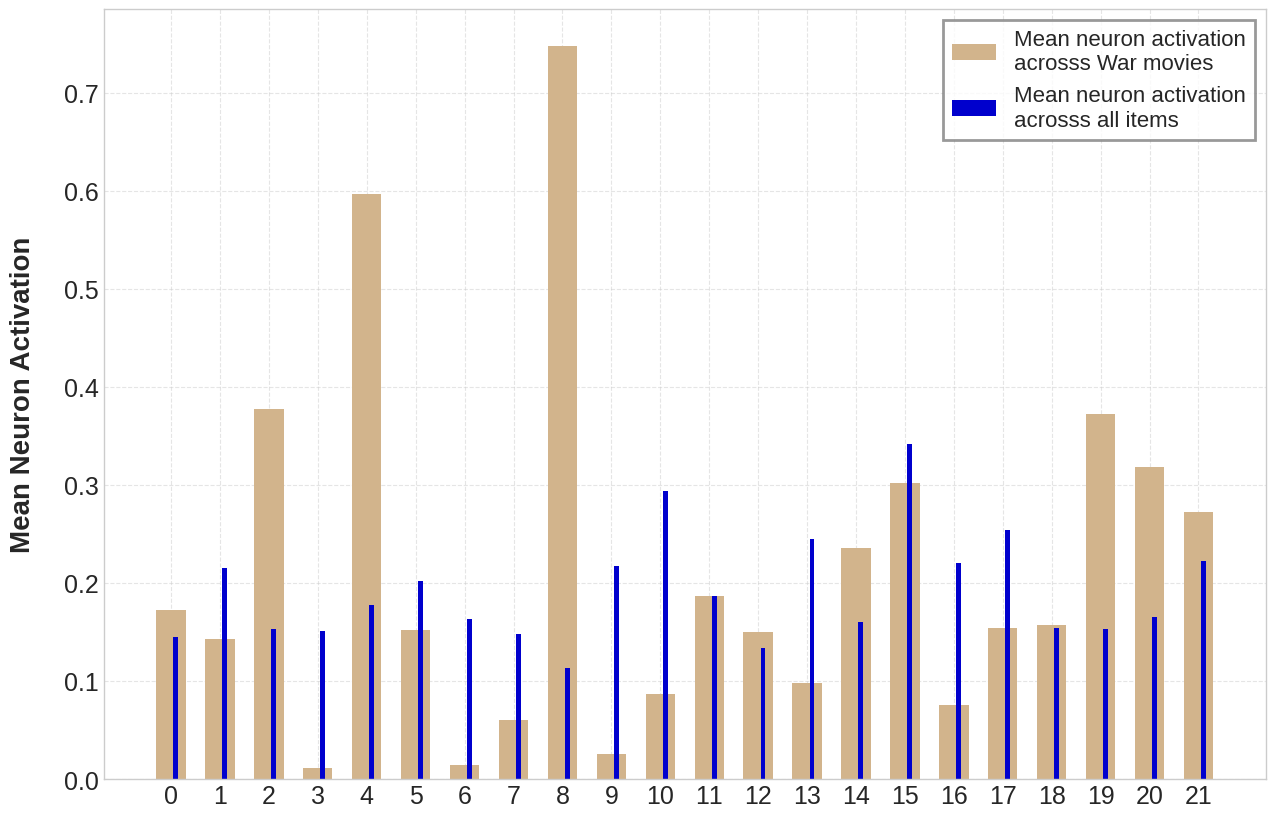

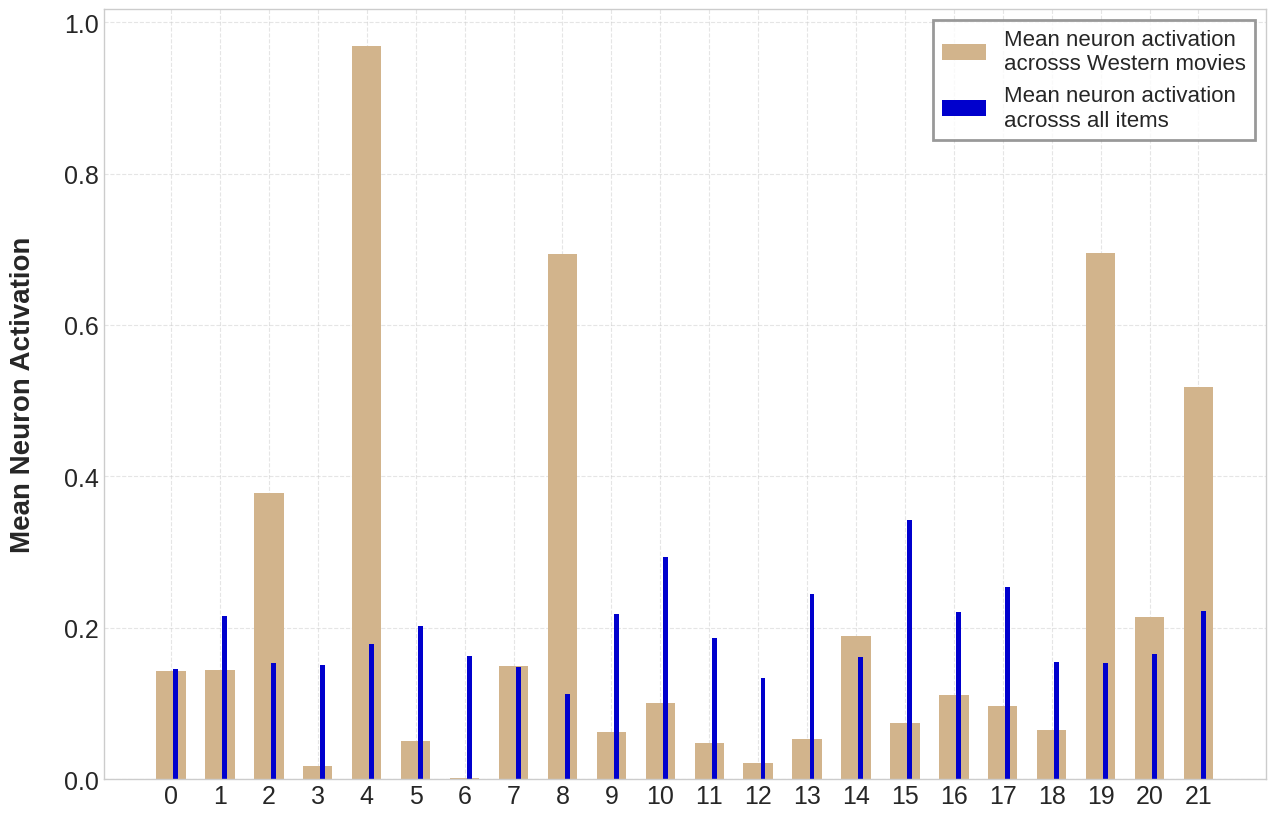

In [ ]:
keys_genres = list(genre_id.keys())

for ind, genre in enumerate(all_genres):

  curr_genre_ind = list(genre_id[(keys_genres[ind])])
  if ind ==1:
      prev_df_genre = curr_df_genre.copy()
      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([prev_df_genre.mean(), curr_df_genre.mean()],axis=1)
  elif ind > 1:
      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([comparison ,curr_df_genre.mean()],axis=1)
  else:
      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]


  # plt.style.use('seaborn-v0_8-whitegrid')

  fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))


  # Calculate mean activation per neuron for documentary movies
  mean_activation = curr_df_genre.mean()

  # Mean activation per neuron
  ax1.bar(latents_items_df.columns, mean_activation, color='tan', width=0.6)
  ax1.bar(latents_items_df.columns+0.1, latents_items_df.mean(), color='mediumblue',width=0.1)


  # ax1.set_title(f'Mean Activation per Neuron - {genre} Movies', pad=20,weight='bold',fontsize=22)
  # ax1.set_xlabel('Neurons', labelpad=20,weight='bold',fontsize=20)
  ax1.set_ylabel('Mean Neuron Activation', labelpad=20,weight='bold',fontsize=20)
  ax1.grid(True, linestyle='--', alpha=0.5)
  ax1.set_xticks(range(len(latents_items_df.columns)))
  ax1.set_xticklabels(latents_items_df.columns,fontsize=18)
  # ax1.tick_params(axis='y', labelsize=14)
  ax1.tick_params(axis='both', which='major', labelsize=18)
  #ax1.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

  leg = ax1.legend([f'Mean neuron activation\nacrosss {genre} movies','Mean neuron activation\nacrosss all items'], loc='upper right', fontsize=16, fancybox=False,frameon=True)
  if ind == 1 or ind == 2 or ind== 3 or ind == 13:
      leg = ax1.legend([f'Mean neuron activation\nacrosss {genre} movies','Mean neuron activation\nacrosss all items'], loc='upper right', fontsize=16, fancybox=False,frameon=True)
  frame = leg.get_frame()
  frame.set_edgecolor('grey')
  frame.set_linewidth(2)



In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'grey'

for index in comparison.index:
  plt.figure(figsize=(16, 8))
  r = plt.bar(all_genres, round(comparison.iloc[index,:],2), color='tan', width=0.6, edgecolor = 'darkgoldenrod', hatch = '//')
  plt.bar_label(r,fontsize=14)
  # plt.title(f'Neuron {index} - Mean Activation over Different Genres', pad=20,weight='bold',fontsize=24)
  # plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
  plt.ylabel('Mean Activation Level', labelpad=20,weight='bold',fontsize=20)
  plt.xticks(rotation=90,fontsize=18)
  plt.yticks(fontsize=18)
  plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw = 2.5)
  plt.grid(True, linestyle='--', alpha=0.5)
  leg = plt.legend([f'Mean neuron {index} activation\nacross all items'], loc='upper right', fontsize=16, fancybox=False)
  if index == 4 or index== 5 or index==12 or index==8 or index==13 or index== 14 or index== 21 or index== 19:
    leg = plt.legend([f'Mean neuron {index} activation\nacross all items'], loc='upper left', fontsize=16, fancybox=False)
  # Access the legend frame and set its edge color and linewidth
  frame = leg.get_frame()
  frame.set_edgecolor('grey')
  frame.set_linewidth(2)

-

# Testing K most dominant movies per neuron
##i.e.- topK movies that yielded the highest activation per neuron.

In [ ]:
'''a data frame contains the 500 most highly activated movies for each neuron
so each spot in the matrix is a movie number'''
size = 200

highly_activate_movies2neurons= pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,size))
for neuron in latents_items_df.columns:
  highly_activate_movies2neurons.loc[neuron,:] = latents_items_df.loc[:,neuron].nlargest(3706)[0:size].index

highly_activate_movies2neurons

,0,1,2,3,4,...,15,16,17,18,19
0,2278,1617,6,1785,164,...,2561,293,2334,1732,3726
1,653,3489,362,1495,546,...,2143,1826,1009,158,1356
2,592,2000,2194,1196,1036,...,3039,2115,2001,3040,2402
3,1513,2706,2492,2683,2598,...,2718,2541,2599,3174,2572
4,897,1943,3196,1928,1283,...,944,1940,1935,1085,1946
...,...,...,...,...,...,...,...,...,...,...,...
17,3340,775,2648,841,1076,...,3550,2186,1329,3739,2664
18,2973,2065,3422,2750,3072,...,2300,1244,52,1948,2108
19,3443,3769,2741,2494,3430,...,2669,1661,3801,2180,3339
20,1792,9,1432,1616,227,...,20,886,786,733,694


## Quantitative results

monosemanticity score

In [ ]:
ms_score_all_neurons(df_cosine_sim_matrix, latents_items)

In [ ]:
for neuron in latents_items_df.columns:
  activated_per_neuron = df_movie.loc[highly_activate_movies2neurons.iloc[neuron,:],:]
  activated_per_neuron = activated_per_neuron.iloc[:,0:-1]
  norm_activated_per_neuron = activated_per_neuron.sum()/size
  plt.figure(figsize=(16, 8))
  r= plt.bar(activated_per_neuron.columns, norm_activated_per_neuron, color='tan', width=0.6, hatch= '//', edgecolor = 'darkgoldenrod')
  plt.bar_label(r,fontsize=14)
  plt.title(f'Neuron {neuron} - Genre Distribution of the {size} Most Dominant Movies', pad=20,weight='bold',fontsize=24)
  plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
  plt.ylabel('Movies Percentage', labelpad=20,weight='bold',fontsize=20)
  plt.xticks(rotation=90, fontsize=18)
  plt.yticks(fontsize=18)
  # plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw = 2.5)
  plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
years_sum_df = pd.DataFrame(0,index=latents_items_df.columns,columns =years_sum.keys() )
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:size]
  years_sum={}

  years_sum['60']=[]
  years_sum['70']=[]
  years_sum['80']=[]
  years_sum['90']=[]
  years_sum['2000']=[]
  # a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
  for movie in a1.index:
    if int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['60'].append(movie)
    if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['70'].append(movie)
    if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['80'].append(movie)
    if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2000:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['90'].append(movie)
    if 2000<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['2000'].append(movie)

  for key in (years_sum.keys()):
    years_sum[key]=round(len(years_sum[key])/size,4)
  years_sum_df.iloc[neuron,:] = years_sum.values()
  years_sum_df.columns = ['1960s and earlier', '1970s', '1980s', '1990s','2000s']


years_sum_df

In [ ]:
activated_per_neuron = df_movie.loc[highly_activate_movies2neurons.iloc[1,:],:]
activated_per_neuron = activated_per_neuron.iloc[:,0:-1]
activated_per_neuron.sum()

,0
Children's,250
Drama,1493
Action,495
Comedy,1163
Adventure,281
Documentary,110
Animation,105
Crime,201
Fantasy,68
Film-Noir,44


In [ ]:
highly_activate_movies2neurons_name=highly_activate_movies2neurons.copy().iloc[:,0:10]
for i in range(highly_activate_movies2neurons_name.shape[0]):
  for j in range(highly_activate_movies2neurons_name.shape[1]):
    highly_activate_movies2neurons_name.iloc[i,j] = df_movie_names.loc[highly_activate_movies2neurons_name.iloc[i,j],1]

highly_activate_movies2neurons_name

,0,1,2,3,4,5,6,7,8,9
0,Ronin (1998),L.A. Confidential (1997),Heat (1995),King of New York (1990),Devil in a Blue Dress (1995),Red Rock West (1992),City of Industry (1997),Midnight Run (1988),Natural Born Killers (1994),Reservoir Dogs (1992)
1,Dragonheart (1996),Hook (1991),"Jungle Book, The (1994)",Turbo: A Power Rangers Movie (1997),Super Mario Bros. (1993),Flubber (1997),"Three Musketeers, The (1993)","Pagemaster, The (1994)",Jumanji (1995),"Rescuers, The (1977)"
2,Batman (1989),Lethal Weapon (1987),"Untouchables, The (1987)",Star Wars: Episode V - The Empire Strikes Back...,Die Hard (1988),"Blues Brothers, The (1980)",Back to the Future (1985),"Jerk, The (1979)",Fletch (1985),Rocky (1976)
3,Romy and Michele's High School Reunion (1997),American Pie (1999),20 Dates (1998),Austin Powers: The Spy Who Shagged Me (1999),Pushing Tin (1999),Big Daddy (1999),Bowfinger (1999),Detroit Rock City (1999),Doctor Dolittle (1998),Superstar (1999)
4,For Whom the Bell Tolls (1943),"Greatest Show on Earth, The (1952)",Stalag 17 (1953),Cimarron (1931),High Noon (1952),"Big Country, The (1958)","Grapes of Wrath, The (1940)","Davy Crockett, King of the Wild Frontier (1955)",In the Heat of the Night (1967),"Treasure of the Sierra Madre, The (1948)"
...,...,...,...,...,...,...,...,...,...,...
17,Bride of the Monster (1956),Spirits of the Dead (Tre Passi nel Delirio) (1...,Frankenstein (1931),Eyes Without a Face (1959),"Innocents, The (1961)",Bride of Frankenstein (1935),Son of Frankenstein (1939),"Masque of the Red Death, The (1964)","Tingler, The (1959)",House of Dracula (1945)
18,Crimes and Misdemeanors (1989),"Purple Rose of Cairo, The (1985)",She's Gotta Have It (1986),Radio Days (1987),Moonstruck (1987),My Favorite Year (1982),Bullets Over Broadway (1994),This Is Spinal Tap (1984),Hear My Song (1991),Hairspray (1988)
19,Born American (1986),Thunderbolt and Lightfoot (1974),No Mercy (1986),"Last Days, The (1998)",Death Wish (1974),52 Pick-Up (1986),Rough Night in Jericho (1967),"Taking of Pelham One Two Three, The (1974)",Breathless (1983),"Sea Wolves, The (1980)"
20,U.S. Marshalls (1998),Sudden Death (1995),Metro (1997),"Peacemaker, The (1997)",Drop Zone (1994),"Specialist, The (1994)","Jackal, The (1997)",Rush Hour (1998),Mad City (1997),Enemy of the State (1998)


## a list of the most dominant movies in a certain neuron

In [ ]:
  '''elaborating on the matrix in the previous code snippet, focus on a specific neuron'''

  neuron_interest = 0
  length = 10
  neuron_data = highly_activate_movies2neurons.iloc[neuron_interest,:]
  highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['Name','Popularity rank','Popularity Percentile' , 'Genres'])
  for i in highly_activate_movies2neurons_table.index[0:30]:
    highly_activate_movies2neurons_table.iloc[i,0] =  df_movie_names.loc[neuron_data[i]].iloc[0]
    highly_activate_movies2neurons_table.iloc[i,1] =  np.where(num_users_per_movie_sort.index == neuron_data[i])[0][0]
    highly_activate_movies2neurons_table.iloc[i,2] =  np.where(num_users_per_movie_sort.index == neuron_data[i])[0][0]*100/3706
    highly_activate_movies2neurons_table.iloc[i,3] =  ','.join(df_movie.columns[(np.where(df_movie.loc[neuron_data[i]]==1)[0])].tolist())
  highly_activate_movies2neurons_table

,Name,Popularity rank,Popularity Percentile,Genres
0,Ronin (1998),309,8.34,"['Action', 'Crime', 'Thriller']"
1,L.A. Confidential (1997),18,0.49,"['Crime', 'Film-Noir', 'Mystery', 'Thriller']"
2,Heat (1995),233,6.29,"['Action', 'Crime', 'Thriller']"
3,King of New York (1990),1517,40.93,"['Action', 'Crime']"
4,Devil in a Blue Dress (1995),845,22.80,"['Crime', 'Film-Noir', 'Mystery', 'Thriller']"
5,Red Rock West (1992),1191,32.14,['Thriller']
6,City of Industry (1997),2552,68.86,"['Crime', 'Thriller']"
7,Midnight Run (1988),340,9.17,"['Action', 'Comedy', 'Adventure', 'Crime']"
8,Natural Born Killers (1994),396,10.69,"['Action', 'Thriller']"
9,Reservoir Dogs (1992),114,3.08,"['Crime', 'Thriller']"


In [ ]:
neuron_interest = 0
length = 10
neuron_data = highly_activate_movies2neurons.iloc[neuron_interest,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['Name','Year', 'Genres'])
for i in highly_activate_movies2neurons_table.index[0:30]:
  highly_activate_movies2neurons_table.iloc[i,0] =  df_movie_names.loc[neuron_data[i]].iloc[0,][0:-6]
  highly_activate_movies2neurons_table.iloc[i,1] =  df_movie_names.loc[neuron_data[i]].iloc[0,][-5:-1]
  highly_activate_movies2neurons_table.iloc[i,2] =  ','.join(df_movie.columns[(np.where(df_movie.loc[neuron_data[i]]==1)[0])].tolist())
highly_activate_movies2neurons_table

,Name,Year,Genres
0,Ronin,1998,"['Action', 'Crime', 'Thriller']"
1,L.A. Confidential,1997,"['Crime', 'Film-Noir', 'Mystery', 'Thriller']"
2,Heat,1995,"['Action', 'Crime', 'Thriller']"
3,King of New York,1990,"['Action', 'Crime']"
4,Devil in a Blue Dress,1995,"['Crime', 'Film-Noir', 'Mystery', 'Thriller']"
5,Red Rock West,1992,['Thriller']
6,City of Industry,1997,"['Crime', 'Thriller']"
7,Midnight Run,1988,"['Action', 'Comedy', 'Adventure', 'Crime']"
8,Natural Born Killers,1994,"['Action', 'Thriller']"
9,Reservoir Dogs,1992,"['Crime', 'Thriller']"


In [ ]:
neuron_interest = 9
length = 20
neuron_data = highly_activate_movies2neurons.iloc[neuron_interest,:]
highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(length), columns=['pop rank', 'name', 'genres'])
for i in highly_activate_movies2neurons_table.index[0:30]:
  highly_activate_movies2neurons_table.iloc[i,0] =  np.where(num_users_per_movie_sort.index == neuron_data[i])[0][0]
  highly_activate_movies2neurons_table.iloc[i,1] =  df_movie_names.loc[neuron_data[i]].iloc[0]
  highly_activate_movies2neurons_table.iloc[i,2] =  ', '.join(df_movie.columns[(np.where(df_movie.loc[neuron_data[i]]==1)[0])].tolist())
highly_activate_movies2neurons_table

,pop rank,name,genres
0,1620,Babes in Toyland (1961),"Children's, Fantasy, Musical"
1,1385,Aladdin and the King of Thieves (1996),"Children's, Comedy, Animation"
2,1895,Madeline (1998),"Children's, Comedy"
3,2452,"Inspector General, The (1949)",Musical
4,2628,"Baby-Sitters Club, The (1995)",Children's
5,2663,Doug's 1st Movie (1999),"Children's, Animation"
6,1562,"Little Princess, A (1995)","Children's, Drama"
7,2978,Little Nemo: Adventures in Slumberland (1992),"Children's, Animation"
8,1178,"Muppet Christmas Carol, The (1992)","Children's, Musical"
9,2729,Fun and Fancy Free (1947),"Children's, Animation, Musical"


# Other concepts:

## Popularity Neuron

In [ ]:
'''we take latent_items_df, sort each columns top value- i.e- i can tell what
are the 500 most dominant movies for each neuron- by the size of their activation.
then we initialize 'pop_rank_df' of size neurons_num X 500 items, we fill in
there the popularity rank of the 500 most dominant movies for each neuron
(calculated earlier), find the mean of the popularilty rank for the 500 most
dominant movies for each neuron..
which describes the 'poplarity level' each neuron might describe'''

pop_rank_df = pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,500))
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:500]
  for id, movie in enumerate(a1.index):
    pop_rank_df.loc[neuron,id]= np.where(num_users_per_movie_sort.index == a1.index[id])[0][0]
pop_rank_df.mean(axis=1)



,0
0,1059.67
1,1151.27
2,595.01
3,1632.27
4,1613.79
...,...
17,2269.10
18,1336.08
19,1939.60
20,1354.54


In [ ]:
# neuron 2 has a relatively low rank fof 595.012

neuron = 2
a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
a1_table = pd.DataFrame(0, index=range(len(a1)), columns=['movie', 'name', 'genres','pop rank'])
for i in a1_table.index:
  a1_table.iloc[i,0] =  a1.index[i]
  a1_table.iloc[i,1] =  df_movie_names.loc[a1.index[i]].iloc[0]
  a1_table.iloc[i,2] =  ','.join(df_movie.columns[(np.where(df_movie.loc[a1.index[i]]==1)[0])].tolist())
  a1_table.iloc[i,3] =  np.where(num_users_per_movie_sort.index == a1.index[i])[0][0]
a1_table

,movie,name,genres,pop rank
0,592,Batman (1989),"['Drama', 'Action', 'Adventure', 'Crime']",77
1,2000,Lethal Weapon (1987),"['Drama', 'Action', 'Comedy', 'Crime']",56
2,2194,"Untouchables, The (1987)","['Drama', 'Action', 'Crime']",151
3,1196,Star Wars: Episode V - The Empire Strikes Back...,"['Drama', 'Action', 'Adventure', 'Sci-Fi', 'War']",2
4,1036,Die Hard (1988),"['Action', 'Thriller']",51
...,...,...,...,...
95,3526,Parenthood (1989),"['Drama', 'Comedy']",304
96,371,"Paper, The (1994)","['Drama', 'Comedy']",1373
97,1272,Patton (1970),"['Drama', 'War']",451
98,1079,"Fish Called Wanda, A (1988)",['Comedy'],104


## decadal distribution

In [ ]:
years_sum={}
years_sum['60']=[]
years_sum['70']=[]
years_sum['80']=[]
years_sum['90']=[]
years_sum['2000']=[]
# a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
for movie in df_movie.index:
  if 1960<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['60'].append(movie)
  if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['70'].append(movie)
  if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['80'].append(movie)
  if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2001:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['90'].append(movie)
  if 2001<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['2000'].append(movie)

for key in (years_sum.keys()):
  years_sum[key]=len(years_sum[key])
years_sum

{'60': 187, '70': 240, '80': 592, '90': 2304, '2000': 0}

In [ ]:
''''decadal distribution for topK most ominant for each neuron'''

movies_num = 200

years_sum_df = pd.DataFrame(0,index=latents_items_df.columns,columns =years_sum.keys() )
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:movies_num]
  years_sum={}

  years_sum['60']=[]
  years_sum['70']=[]
  years_sum['80']=[]
  years_sum['90']=[]
  years_sum['2000']=[]
  # a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
  for movie in a1.index:
    if int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
      years_sum['60'].append(movie)
    if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
      years_sum['70'].append(movie)
    if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
      years_sum['80'].append(movie)
    if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2000:
      years_sum['90'].append(movie)
    if 2000<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
      years_sum['2000'].append(movie)

  for key in (years_sum.keys()):
    years_sum[key]=round(len(years_sum[key])/movies_num,3)
  years_sum_df.iloc[neuron,:] = years_sum.values()
  years_sum_df.columns = ['1960s and earlier', '1970s', '1980s', '1990s','2000s']


years_sum_df

## sanity check- separation into year of specific genre

In [ ]:
# childdrens movies only:
years_sum_genre={}
years_sum_genre['60']=[]
years_sum_genre['70']=[]
years_sum_genre['80']=[]
years_sum_genre['90']=[]
years_sum_genre['2000']=[]

genre = 'Comedy' #'Romance' #'Children\'s'
for movie in df_movie.index[np.where(df_movie.loc[:,genre]==1)]: # movie numbers of specific genre
  if 1960<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum_genre['60'].append(movie)
  if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum_genre['70'].append(movie)
  if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum_genre['80'].append(movie)
  if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2001:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum_genre['90'].append(movie)
  if 2001<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum_genre['2000'].append(movie)

for key in (years_sum_genre.keys()):
  years_sum_genre[key]=len(years_sum_genre[key])
years_sum_genre

{'60': 41, '70': 62, '80': 199, '90': 782, '2000': 0}

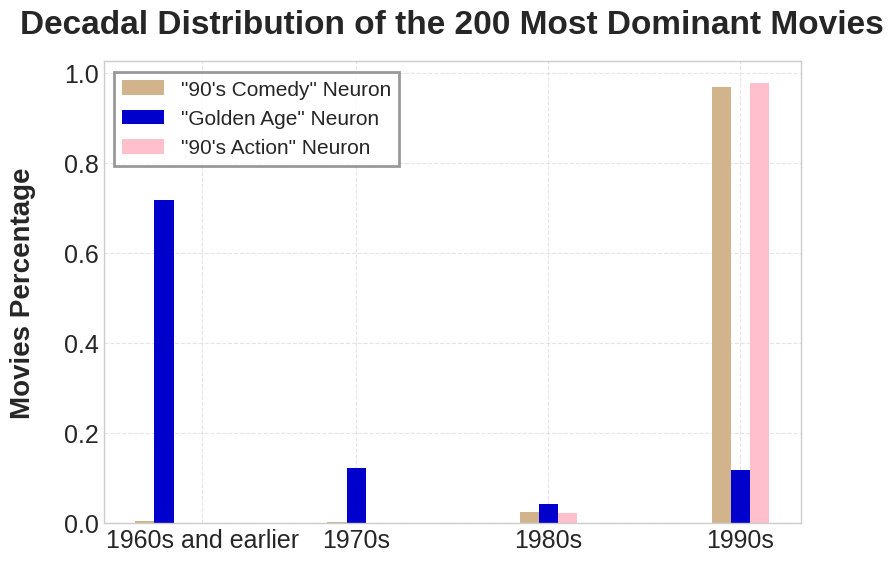

In [ ]:
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'grey'

plt.figure(figsize=(9, 6))
r1=plt.bar([-0.1,0.9,1.9,2.9], years_sum_df.iloc[3,:], color='tan', width=0.1)
# plt.bar_label(r1,fontsize=14)
r2=plt.bar([0,1,2,3], years_sum_df.iloc[4,:], color='mediumblue', width=0.1)
# plt.bar_label(r2,fontsize=14)
r3 = plt.bar([0.1, 1.1, 2.1,3.1], years_sum_df.iloc[20,:], color='pink', width=0.1)
# plt.bar_label(r3,fontsize=14)


plt.title(f'Decadal Distribution of the 200 Most Dominant Movies', pad=20,weight='bold',fontsize=24)
# plt.xlabel('Dec', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Movies Percentage', labelpad=20,weight='bold',fontsize=20)
plt.xticks([0.2,1,2,3], labels = list(years_sum_df.columns),fontsize=18)
plt.yticks(fontsize=18)
# plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw = 2.5)
plt.grid(True, linestyle='--', alpha=0.5)
leg = plt.legend([f'"90\'s Comedy" Neuron', f'"Golden Age" Neuron', '"90\'s Action" Neuron'],frameon=True, loc='best', fontsize=15, fancybox=False)
# Access the legend frame and set its edge color and linewidth
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)


-

# Further Latent Analysis and Manipulations:


## Activate one neuron in Latent representation

In [ ]:
movie = 1566
movie_ind = np.where(ratings_matrix.columns == movie)[0][0]

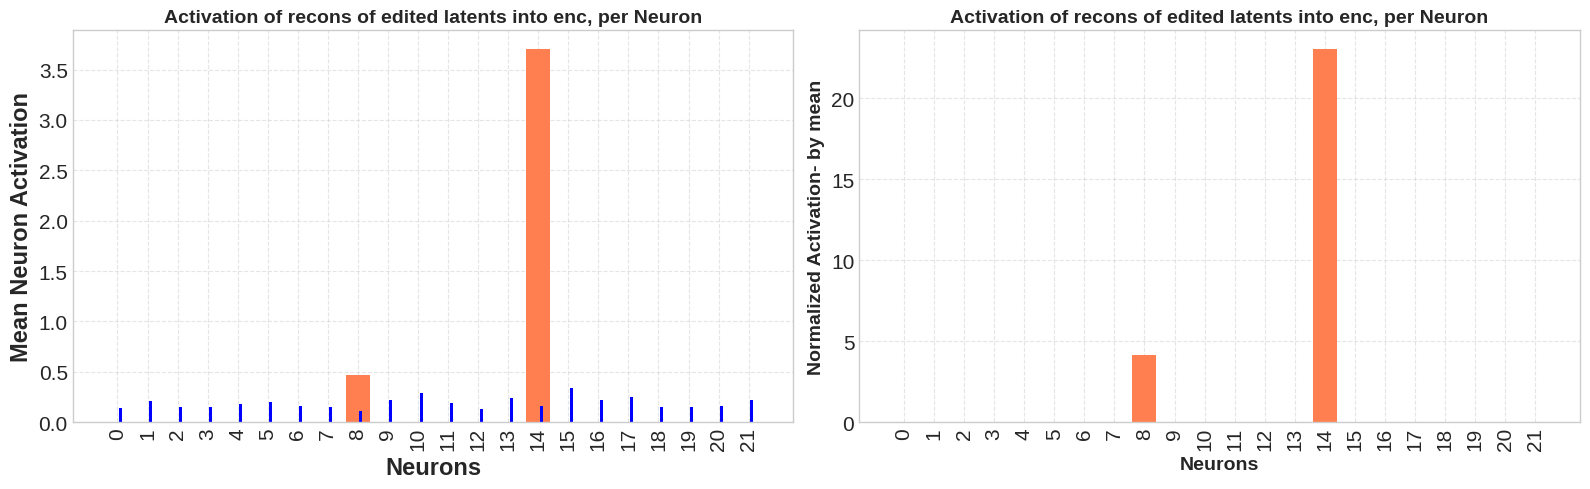

 mean popularity rank 2041.8
division movies into years: {'30': 0, '40': 0, '50': 7, '60': 1, '70': 1, '80': 1, '90': 0, '2000': 0}




,movie,name,genres,pop rank
0,2658,"Flying Saucer, The (1950)",['Sci-Fi'],3204
1,2663,It Came from Beneath the Sea (1955),['Sci-Fi'],2468
2,2495,"Fantastic Planet, The (La Planète sauvage) (1973)","['Animation', 'Sci-Fi']",2025
3,3937,Runaway (1984),"['Sci-Fi', 'Thriller']",1773
4,2660,"Thing From Another World, The (1951)",['Sci-Fi'],1786
5,3927,Fantastic Voyage (1966),"['Adventure', 'Sci-Fi']",932
6,1301,Forbidden Planet (1956),['Sci-Fi'],860
7,3780,Rocketship X-M (1950),['Sci-Fi'],2634
8,3375,Destination Moon (1950),['Sci-Fi'],2334
9,2667,"Mole People, The (1956)",['Sci-Fi'],2402


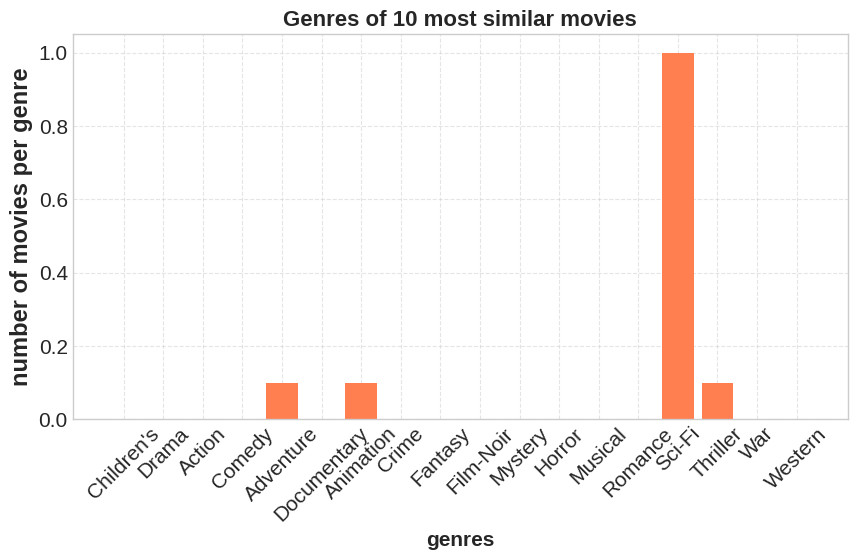

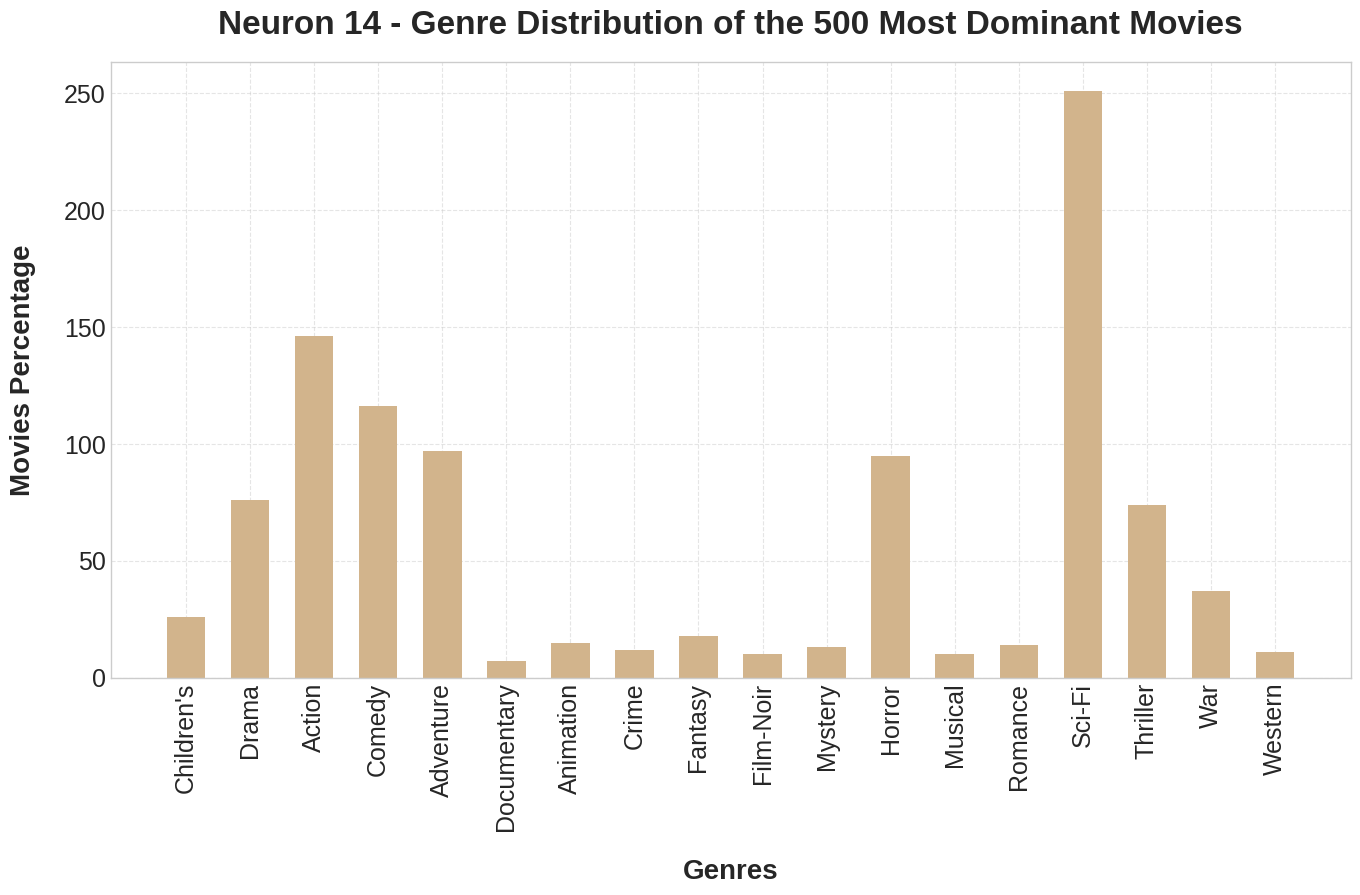

In [ ]:
x = np.array(np.array(dataset_items[1016]))

# dataset_items1 = normalize_matrix(torch.Tensor(dataset_items))
# dataset_items1 = pad_or_truncate_tensor(dataset_items1, 20)

latents_pre_act_items, latents_items, reconstructions_items = autoencoder(dataset_items)

latents_items_numpy_array = latents_items.detach().clone().numpy()
latents_items_df = pd.DataFrame(latents_items_numpy_array)
latents_items_df.index = ratings_matrix.columns

# _, latents_df, _ = autoencoder(np.array(recons_unique.detach().numpy()))
#  21 20 18 16 15 14 11 10 9 0 1 4

# autoencoder == self in the original code
x, info = autoencoder.preprocess(x)
cuur_latents_pre_act = autoencoder.encode_pre_act(x)
curr_latents = autoencoder.activation(cuur_latents_pre_act)
curr_latents = torch.zeros_like(curr_latents)
# print(curr_latents)
# changes and modifictions to the encoder's output!
neuron_one = 14
level = 2
curr_latents[neuron_one]=level
recons_unique = autoencoder.decode(curr_latents, info)



#-----------------------------------------------------------------------------------------------------------------------------------

_, editeEncOut_recons_latents, _ = autoencoder(np.array(recons_unique.detach().numpy()))
df_editeEncOut_recons_latents_post_enc = pd.DataFrame(editeEncOut_recons_latents.detach().numpy())

df_recons_edited = pd.DataFrame(recons_unique.detach().numpy())

score_low = {}
score_high = {}


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

# First bar chart: Mean activation per neuron
ax1.bar(latents_items_df.columns, df_editeEncOut_recons_latents_post_enc[0], color='coral')
ax1.bar(latents_items_df.columns+0.1, latents_items_df.mean(), color='blue',width=0.1)

ax1.set_title(f'Activation of recons of edited latents into enc, per Neuron',fontsize=14, weight='bold')
ax1.set_xlabel('Neurons',fontsize=17, weight='bold')
ax1.set_ylabel('Mean Neuron Activation',fontsize=17, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(range(len(latents_items_df.columns)))
ax1.set_xticklabels(latents_items_df.columns, rotation=90,fontsize=15)
ax1.tick_params(axis='y', labelsize=15)


plt.tight_layout()

plt.show()

score_low[genre] = list(np.where(normalized_activation >= 1.2)[0])
score_high[genre] = list(np.where(normalized_activation >= 2.5)[0])


#-----------------------------------------------------------------------------------------------------------------------------------


movie_num = 10
movie_num_test = 10

cosine_res = {}

test_mod_recons_embeddings = recons_unique
df_test_mod_recons_embeddings = pd.DataFrame(test_mod_recons_embeddings.detach().numpy())
magnitude_test_mod_recons_embeddings = np.linalg.norm(df_test_mod_recons_embeddings) ## TODO- maybe [0]

for i, movie_id in enumerate(ratings_matrix.columns):
  # if i in train_subset:
    curr_dot_product = np.dot(df_item_emb1.loc[movie_id],df_test_mod_recons_embeddings[0])
    curr_magnitude = np.linalg.norm(df_item_emb1.loc[movie_id])
    curr_cosine_similarity = curr_dot_product / (magnitude_test_mod_recons_embeddings * curr_magnitude)

    cosine_res[movie_id] = curr_cosine_similarity

max_key = max(cosine_res, key=cosine_res.get)
genres_test_mod_recons_embeddings = df_movie.columns[(np.where(df_movie.loc[max_key]==1)[0])].tolist()
topK_test_mod_recons_embeddings = heapq.nlargest(movie_num, cosine_res.items(), key=lambda x: x[1])


#-----------------------------------------------------------------------------------------------------------------------------------


table1_Wname = pd.DataFrame(0, index=range(movie_num), columns=['movie', 'name', 'genres','pop rank'])
for i in table1_Wname.index:
  table1_Wname.iloc[i,0] =  topK_test_mod_recons_embeddings[i][0]
  table1_Wname.iloc[i,1] =  (df_movie_names.loc[topK_test_mod_recons_embeddings[i][0]]).loc[1]
  table1_Wname.iloc[i,2] =  '.'.join(df_movie.columns[(np.where(df_movie.loc[topK_test_mod_recons_embeddings[i][0]]==1)[0])].tolist())
  table1_Wname.iloc[i,3] =  np.where(num_users_per_movie_sort.index == topK_test_mod_recons_embeddings[i][0])[0][0]

print(f' mean popularity rank {table1_Wname.iloc[:,3].mean()}')


years_sum={}
years_sum['70']=[]
years_sum['80']=[]
years_sum['90']=[]
years_sum['2000']=[]
# a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
for movie in table1_Wname.iloc[:,0]:
  if int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['60'].append(movie)
  if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['70'].append(movie)
  if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['80'].append(movie)
  if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2001:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['90'].append(movie)
  if 2001<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['2000'].append(movie)

for key in (years_sum.keys()):
  years_sum[key]=len(years_sum[key])
print(f'division movies into years: {years_sum}')


print('\n')


#-----------------------------------------------------------------------------------------------------------------------------------



a=[topK_test_mod_recons_embeddings[i][0] for i in range(len(topK_test_mod_recons_embeddings))]
b = (df_movie.loc[a]).iloc[:,0:-1]


plt.figure(figsize=(10, 5))
numerator = (df_movie.loc[a].sum(axis=0)[0:-2]) if 'Cluster' in df_movie.columns else (df_movie.loc[a].sum(axis=0)[0:-1])

plt.bar(all_genres, numerator/movie_num, color='coral')
plt.title(f'Genres of {movie_num} most similar movies',fontsize=16, weight='bold')
plt.xlabel('genres',fontsize=15, weight='bold')
plt.ylabel('number of movies per genre',fontsize=17, weight='bold')
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)


#--------------------------------------------------------------------------------------------------------------------------------------


activated_per_neuron = df_movie.loc[highly_activate_movies2neurons.iloc[neuron_one,:],:]
activated_per_neuron = activated_per_neuron.iloc[:,0:-1]
norm_activated_per_neuron = activated_per_neuron.sum()#/500
plt.figure(figsize=(16, 8))
plt.bar(activated_per_neuron.columns, norm_activated_per_neuron, color='tan', width=0.6)
plt.title(f'Neuron {neuron_one} - Genre Distribution of the 500 Most Dominant Movies', pad=20,weight='bold',fontsize=24)
plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Movies Percentage', labelpad=20,weight='bold',fontsize=20)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw = 2.5)
plt.grid(True, linestyle='--', alpha=0.5)


table1_Wname


-

-

-

In [ ]:
N=20

# USE CASES

## generate new audience out of test set

In [ ]:
'''find the group'''
'''list of users that watched movies of certain genre, sorted by the number of
movies of the certain genre wrt the total number of movies ranked by the user'''
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

usersGroup = generate_users_test_group('Children\'s', N, autoencoder)
usersGroup

,percentage of Children's movies
2998,0.962963
4539,0.614865
1727,0.595745
3978,0.587629
1347,0.546763
1110,0.545455
1494,0.543956
2978,0.500000
5749,0.500000
489,0.480519


## test some of the users in the group

## Analyze for a specific user

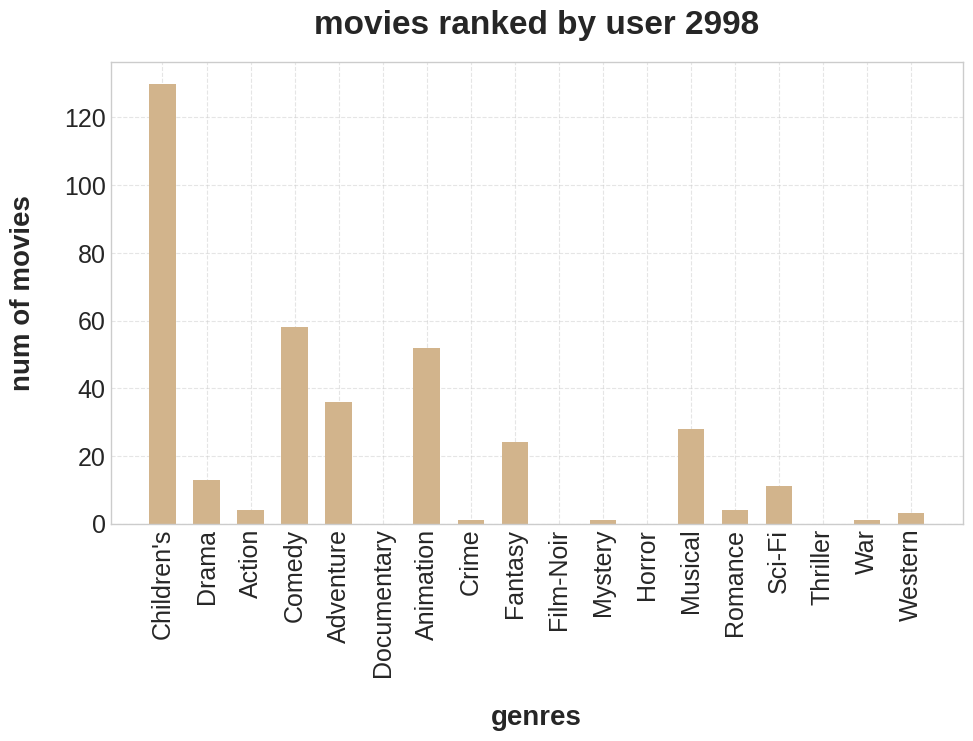

,movie,name,genres,pop rank
0,1,Toy Story (1995),"Children's,Comedy,Animation,movie_id",29
1,2,Jumanji (1995),"Children's,Adventure,Fantasy",394
2,8,Tom and Huck (1995),"Children's,Adventure",2281
3,34,Babe (1995),"Children's,Drama,Comedy",39
4,60,"Indian in the Cupboard, The (1995)","Children's,Adventure,Fantasy",899
5,107,Muppet Treasure Island (1996),"Children's,Comedy,Adventure,Musical",1196
6,126,"NeverEnding Story III, The (1994)","Children's,Adventure,Fantasy",2019
7,158,Casper (1995),"Children's,Adventure",1186
8,239,"Goofy Movie, A (1995)","Children's,Comedy,Animation,Romance",1582
9,241,Fluke (1995),"Children's,Drama",2831


In [ ]:
user =2998
'''ranked movies '''

ranked_movies_index = np.where(ratings_matrix.iloc[user]==1)[0]
ranked_movies_name = ratings_matrix.columns[np.where(ratings_matrix.iloc[user]==1)[0]]
genre_histogram = df_movie.iloc[ranked_movies_index,:-1].sum()


plt.figure(figsize=(11, 6))
plt.bar(all_genres, genre_histogram, color='tan', width=0.6)
plt.title(f'movies ranked by user {user}', pad=20,weight='bold',fontsize=24)
plt.ylabel('num of movies', labelpad=20,weight='bold',fontsize=20)
plt.xlabel('genres', labelpad=20,weight='bold',fontsize=20)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

#------------------------------------------------------------------------------


table1_rec_Wname = pd.DataFrame(0, index=range(len(ranked_movies_name)), columns=['movie', 'name', 'genres','pop rank'])
for i in table1_rec_Wname.index:
  table1_rec_Wname.iloc[i,0] =  ranked_movies_name[i]
  table1_rec_Wname.iloc[i,1] =  df_movie_names.loc[ranked_movies_name[i]].iloc[0]
  table1_rec_Wname.iloc[i,2] =  ','.join(df_movie.columns[(np.where(df_movie.loc[ranked_movies_name[i]]==1)[0])].tolist())
  table1_rec_Wname.iloc[i,3] =  np.where(num_users_per_movie_sort.index == ranked_movies_name[i])[0][0]


table1_rec_Wname

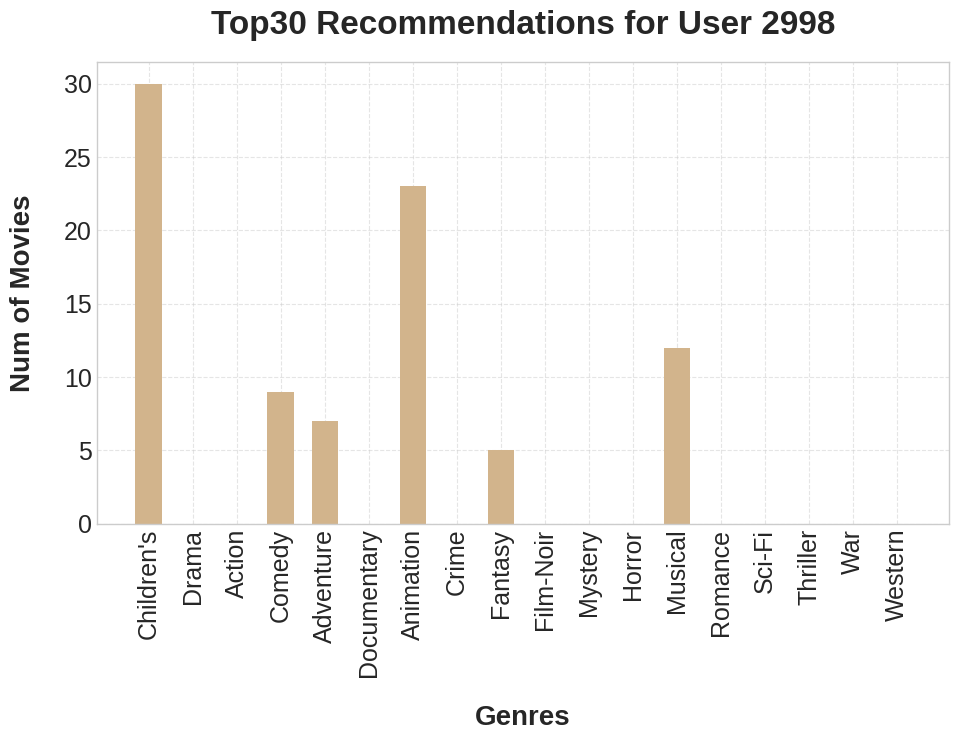

,movie,name,genres,pop rank
0,1032,Alice in Wonderland (1951),"[""Children's"", 'Animation', 'Musical']",585
1,1064,Aladdin and the King of Thieves (1996),"[""Children's"", 'Comedy', 'Animation']",1385
2,2078,"Jungle Book, The (1967)","[""Children's"", 'Comedy', 'Animation', 'Musical']",435
3,2090,"Rescuers, The (1977)","[""Children's"", 'Animation']",1214
4,1566,Hercules (1997),"[""Children's"", 'Comedy', 'Adventure', 'Animati...",671
5,1025,"Sword in the Stone, The (1963)","[""Children's"", 'Animation']",1079
6,1029,Dumbo (1941),"[""Children's"", 'Animation', 'Musical']",529
7,60,"Indian in the Cupboard, The (1995)","[""Children's"", 'Adventure', 'Fantasy']",899
8,661,James and the Giant Peach (1996),"[""Children's"", 'Animation', 'Musical']",584
9,2142,"American Tail: Fievel Goes West, An (1991)","[""Children's"", 'Comedy', 'Animation']",1417


In [ ]:
movie_num = 30

top_rec_user_id = rec_gen(movie_num, user, df_b_u_emb, df_b_i_emb, df_user_emb.iloc[user,:], df_item_emb)


# As a list of (row_idx, column_name) tuples
rec_genre_hist = df_movie.iloc[top_rec_user_id,:-1].sum()


plt.figure(figsize=(11, 6))
plt.bar(all_genres, rec_genre_hist, color='tan', width=0.6)
plt.title(f'Top{movie_num} Recommendations for User {user}', pad=20,weight='bold',fontsize=24)
plt.ylabel('Num of Movies', labelpad=20,weight='bold',fontsize=20)
plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=18)
plt.yticks(fontsize=18)
plt.show()


table1_rec_Wname = table_maker(movie_num, top_rec_user_id, df_movie, df_movie_names, num_users_per_movie_sort)


table1_rec_Wname

# SAE model dependent

In [ ]:
latents_pre_act_usr, latents_usr, reconstructions_usr = autoencoder(dataset_users)


latents_numpy_array_usr = latents_usr.detach().numpy()
latents_df_usr = pd.DataFrame(latents_numpy_array_usr)
latents_df_usr.index = df_user_emb.index


recons_numpy_array_usr = reconstructions_usr.detach().numpy()
recons_df_usr = pd.DataFrame(recons_numpy_array_usr)
recons_df_usr.index = df_user_emb.index

In [ ]:
latents_pre_act, latents, reconstructions = autoencoder(dataset_items)

latents_numpy_array = latents.detach().numpy()
latents_df = pd.DataFrame(latents_numpy_array)
latents_df.index = ratings_matrix.columns


In [ ]:
_, latents_item, reconstruction_item = autoencoder(dataset_items)

latents_item_numpy_array = latents_item.detach().numpy()
latents_item_df = pd.DataFrame(latents_item_numpy_array)
latents_item_df.index = ratings_matrix.columns

reconstruction_item_numpy_array = reconstruction_item.detach().numpy()
reconstruction_item_df = pd.DataFrame(reconstruction_item_numpy_array)
reconstruction_item_df.index = ratings_matrix.columns


# Test users and **reconstruction**:

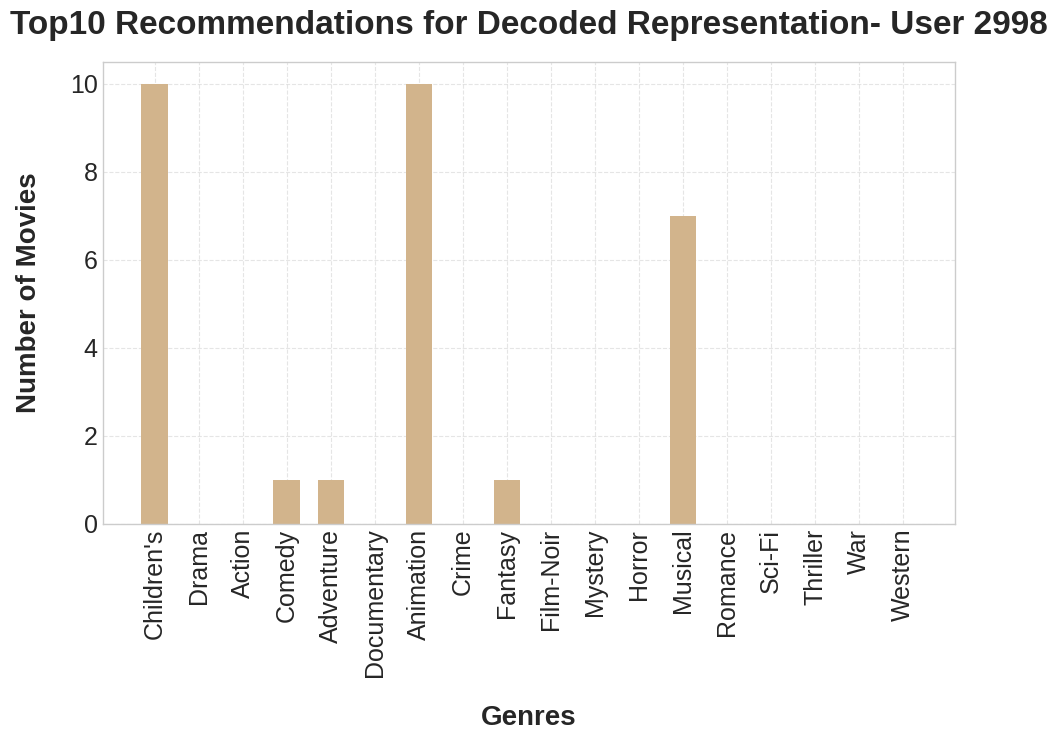

1032 0
reconstruction metrics:
percentile rank is: 0.0
MRR is: 1.0
NDCG is: 1.0
intersection movies: [1032, 2090, 1566, 1029, 661, 2089, 1022, 2087, 2096], length: 9


,Name,Movie ID,Genre
1,Alice in Wonderland (1951),1032,"Children's, Animation, Musical"
2,Cinderella (1950),1022,"Children's, Animation, Musical"
3,Dumbo (1941),1029,"Children's, Animation, Musical"
4,"Rescuers, The (1977)",2090,"Children's, Animation"
5,Peter Pan (1953),2087,"Children's, Animation, Fantasy, Musical"
6,Sleeping Beauty (1959),2096,"Children's, Animation, Musical"
7,Hercules (1997),1566,"Children's, Comedy, Adventure, Animation, Musical"
8,"Rescuers Down Under, The (1990)",2089,"Children's, Animation"
9,101 Dalmatians (1961),2085,"Children's, Animation"
10,James and the Giant Peach (1996),661,"Children's, Animation, Musical"


In [ ]:
user = 2998#2885#2998#4902
movie_num =10

# P of certain user multiplied by all Q's
a_=df_user_emb.loc[user,:].copy()
b_=df_item_emb.copy()
for i in range(a_.shape[0]):
  a_.iloc[i]= recons_df_usr.loc[user,i]
for i in range(b_.shape[0]):
  b_.iloc[i]= reconstruction_item_df.iloc[i,:]

top_rec_user_id = rec_gen(movie_num, user, df_b_u_emb, df_b_i_emb, a_, df_item_emb)

# As a list of (row_idx, column_name) tuples
genre_hist = df_movie.iloc[top_rec_user_id,:-1].sum()


plt.figure(figsize=(11, 6))
plt.bar(all_genres, genre_hist, color='tan', width=0.6)
plt.title(f'Top{movie_num} Recommendations for Decoded Representation- User {user}', pad=20,weight='bold',fontsize=24)
plt.ylabel('Number of Movies' ,labelpad=20,weight='bold',fontsize=20)
plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=18)
plt.yticks(fontsize=18)
plt.show()

#------------------------------------------------------------------------------
table1_recons_Wname = table_maker_new(movie_num, top_rec_user_id, df_movie, df_movie_names, num_users_per_movie_sort)

table1_recons_Wname

# reconstruction test:
rec_items = table1_rec_Wname.iloc[:,0] # ground truth
rec_recons_itmes = table1_recons_Wname.iloc[:,1]
percentile_rank = 0
n_rel_items = 0
dcg = 0
mrr = 0
NDCG = 0
rel_item_exist = 0
# print(rec_items[0])
for ind, item2 in enumerate(rec_recons_itmes):
  print(item2, ind)
  if item2 == rec_items[0]:
    rel_item_exist = 1
    # percentile_rank += (ind/3706)*100
    percentile_rank = 100*ind/len(rec_recons_itmes)
    mrr = 1/(ind+1)
    dcg += 1 / np.log2(ind + 1 + 1)
    idcg = 1  # ideal DCG - 1 / np.log2(0 + 2)
    NDCG = dcg/idcg
    break
  elif ind==(rec_recons_itmes.shape[0]-1) & rel_item_exist==0:
    percentile_rank = np.inf
    mrr = np.inf
    NDCG = np.inf
    # HRatK =
print('reconstruction metrics:')
print(f'percentile rank is: {percentile_rank}')
print(f'MRR is: {mrr}')
print(f'NDCG is: {NDCG}')


intersection = []
for ind1, item1 in enumerate(rec_items):
  for ind2, item2 in enumerate(rec_recons_itmes):
    if item2 == item1:

      intersection.append(item2)
      break

print(f'intersection movies: {intersection}, length: {len(intersection)}')

intersection_table = pd.DataFrame(0, index=range(len(intersection)), columns=['movie', 'name', 'genres','pop rank'])
for i in intersection_table.index:
  intersection_table.iloc[i,0] =  intersection[i]
  intersection_table.iloc[i,1] =  df_movie_names.loc[intersection[i]].iloc[0]
  intersection_table.iloc[i,2] =  str(df_movie.columns[(np.where(df_movie.loc[intersection[i]]==1)[0])].tolist())
  intersection_table.iloc[i,3] =  np.where(num_users_per_movie_sort.index ==intersection[i])[0][0]

# print(intersection_table)

table1_recons_Wname.index = range(1,movie_num+1)
table1_recons_Wname

# intersection_table

# Modify items latent representation:

## test the picked user wrt itrem

In [ ]:
'''what place 'test_movie' has among all recommendations of 'user_movie_test' '''

test_movie = 1032
ind_movie = np.where(ratings_matrix.columns==test_movie)[0][0]
user_movie_test=2998#2885#4617#1283 #4617 #2998
# user 3800, test_movie = 1969
movie_num = 30#3706


top_rec_user_id = rec_gen(movie_num, user_movie_test, df_b_u_emb, df_b_i_emb, df_user_emb.iloc[user_movie_test,:], df_item_emb)

# As a list of (row_idx, column_name) tuples
a = df_movie.iloc[top_rec_user_id,:-1].sum()

table1_rec_Wname_all = table_maker(movie_num, top_rec_user_id, df_movie, df_movie_names, num_users_per_movie_sort)


print(f'{user_movie_test} users original recomendation rank for movie {test_movie} is: {np.where(table1_rec_Wname_all.iloc[:,0]==test_movie)[0][0]}')
print(f'list of {movie_num} original recommendations for user {user_movie_test}:')
table1_rec_Wname_all


2998 users original recomendation rank for movie 1032 is: 0
list of 30 original recommendations for user 2998:


,movie,name,genres,pop rank
0,1032,Alice in Wonderland (1951),"[""Children's"", 'Animation', 'Musical']",585
1,1064,Aladdin and the King of Thieves (1996),"[""Children's"", 'Comedy', 'Animation']",1385
2,2078,"Jungle Book, The (1967)","[""Children's"", 'Comedy', 'Animation', 'Musical']",435
3,2090,"Rescuers, The (1977)","[""Children's"", 'Animation']",1214
4,1566,Hercules (1997),"[""Children's"", 'Comedy', 'Adventure', 'Animati...",671
...,...,...,...,...
25,3157,Stuart Little (1999),"[""Children's"", 'Comedy']",591
26,2137,Charlotte's Web (1973),"[""Children's"", 'Animation']",620
27,1023,Winnie the Pooh and the Blustery Day (1968),"[""Children's"", 'Animation']",1318
28,673,Space Jam (1996),"[""Children's"", 'Comedy', 'Adventure', 'Animati...",540


# user case 1- Modify Item Latent Representation

## Item Exposure to new audience-
childrens movie- alice in wonderland to romance movies audience

In [ ]:
'''find the group'''
'''list of users that watched movies of certain genre, sorted by the number of
movies of the certain genre wrt the total number of movies ranked by the user'''
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

user_group_romance = generate_users_test_group('Romance', N, autoencoder)
user_group_romance

In [ ]:
# list_user = [2872,1754,309,1011,1552,4566,5277,2733,4928,5742,5554,1475,5617,1963,5236,193, 4398, 5703,5754,1633]
# target_genre = 13
# user_group_romance = pd.DataFrame(0, index=range(len(list_user)), columns=['user', 'percentage'])
# for ind, user in enumerate(list_user):
#   # print(user in autoencoder.test_subset_users_ind)
#   user_group_romance.iloc[ind,0] = user
#   p = np.where(ratings_matrix.loc[user]==1)
#   user_group_romance.iloc[ind,1] = df_movie.iloc[p[0],0:-1].sum().iloc[target_genre]/df_movie.iloc[p[0],0:-1].sum().sum()  # 13- romance

# user_group_romance.nlargest(20,  columns = ['percentage'])
# # user_group_romance

graph of how many users in the relevant group , the relevant item entered into

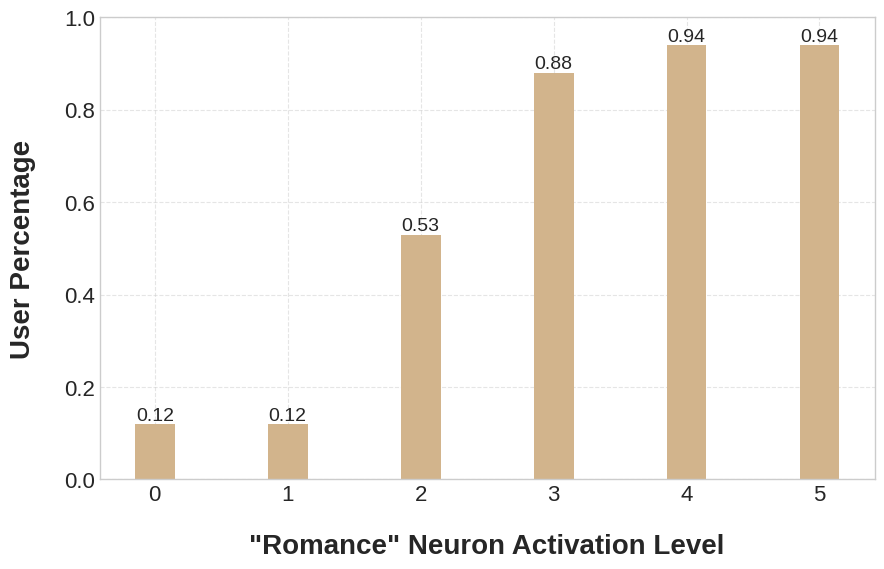

In [ ]:
numUsersTotopk = []
numUsersOuttopk_orig = []
movie_num = 3706
user = 2998
test_movie = 1032 # Alice in Wonderland
ind_movie = np.where(ratings_matrix.columns==test_movie)[0][0]
th = 20

target_neuron = 5



neuron_levels = [0, 1,2,3,4,5]


'''what place 'test_movie' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(user_group_romance.index)), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:
  print(f'level: {level}')

  for ind,user_movie_test in enumerate(user_group_romance['user']):


    # modified movie:
    movie_act =  latents_item_df.loc[test_movie,:]
    movie_act_new = movie_act.copy(deep=True)
    movie_act_new.iloc[target_neuron] = level

    x = np.array(np.array(dataset_items[ind_movie]))
    x, info = autoencoder.preprocess(x)
    curr_latents = torch.from_numpy(movie_act_new.values)
    recons = autoencoder.decode(curr_latents,info)

    df_item_emb_copy= df_item_emb.copy(deep=True)
    df_item_emb_copy.iloc[ind_movie,:]=pd.DataFrame(recons.detach().numpy()).iloc[:,0]

    if level == 0 :
      top_rec_user_id_orig = rec_gen(movie_num, user_movie_test, df_b_u_emb, df_b_i_emb, df_user_emb.iloc[user_movie_test,:], df_item_emb_copy)
      table1_rec_Wname_orig = table_maker(movie_num, top_rec_user_id_orig, df_movie, df_movie_names, num_users_per_movie_sort)

    top_rec_user_id_new = rec_gen(movie_num, user_movie_test, df_b_u_emb, df_b_i_emb, df_user_emb.iloc[user_movie_test,:], df_item_emb_copy)
    table1_rec_Wname_new = table_maker(movie_num, top_rec_user_id_new, df_movie, df_movie_names, num_users_per_movie_sort)

    #--------------------------------------------------------------------------------------

    table.iloc[ind,0] = user_movie_test
    if level == 0 :
      table.iloc[ind,1] = np.where(table1_rec_Wname_orig.iloc[:,0]==test_movie)[0][0]
    table.iloc[ind,2] = np.where(table1_rec_Wname_new.iloc[:,0]==test_movie)[0][0]

  to_top50 = []
  remain_top50 = []
  from_top50 = []
  count_in_top50_orig = 0
  count_out_top50_orig = 0
  for i in table.index:
    if table.iloc[i,1]>th:
      count_out_top50_orig+=1
      # ease on harder mission
      if table.iloc[i,2] <= th+10:
        to_top50.append(table['user'][i])

    else: continue

  numUsersOuttopk_orig.append(count_out_top50_orig)
  numUsersTotopk.append(len(to_top50))



fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

a = [round(ob/numUsersOuttopk_orig[0],2) for ob in numUsersTotopk]
r = ax1.bar(neuron_levels, a, color='tan',width = 0.3)
ax1.bar_label(r,fontsize=14)

ax1.set_xlabel('"Romance" Neuron Activation Level', labelpad=20,weight='bold',fontsize=20)
ax1.set_ylabel('User Percentage', labelpad=20,weight='bold',fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)
# ax1.legend(['Number of users whose original\ntop20 recommendations list\ndoes not contain the relevant movie'
#             ],loc ='center left')
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticks(neuron_levels)
# ax1.set_xticklabels(neuron_levels,fontsize=18)



# Latent user representation intervention

Generate new audience

In [ ]:
'''find the group'''
'''list of users that watched movies of certain genre, sorted by the number of
movies of the certain genre wrt the total number of movies ranked by the user'''
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

demoUsersGroup = generate_users_test_group('Children\'s', N, autoencoder)
demoUsersGroup

youngers in test group

In [ ]:
youngers = df_usr.iloc[np.where(df_usr['age']<18 )[0],:]  #and df_usr['age'] in autoencoder.test_subset_users_ind
indices = np.where(youngers['usr_id'].isin(autoencoder.test_subset_users_ind))[0]
youngers = youngers.iloc[indices, :]

In [ ]:
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

genre_id = 0  #  children's- id in all_genre list
user_group_young = pd.DataFrame(0, index=range(youngers.shape[0]), columns=['user', 'percentage'])
for ind, user in enumerate(youngers['usr_id']):
  user_group_young.iloc[ind,0] = user
  p = np.where(ratings_matrix.loc[user]==1)
  user_group_young.iloc[ind,1] = df_movie.iloc[p[0],0:-1].sum().iloc[genre_id]/df_movie.iloc[p[0],0:-1].sum().sum()


Examine one users' latent manipulation's effect

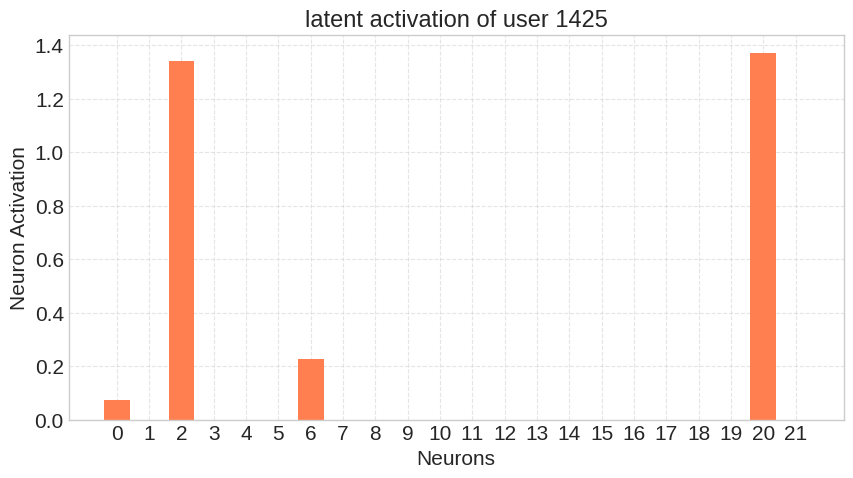

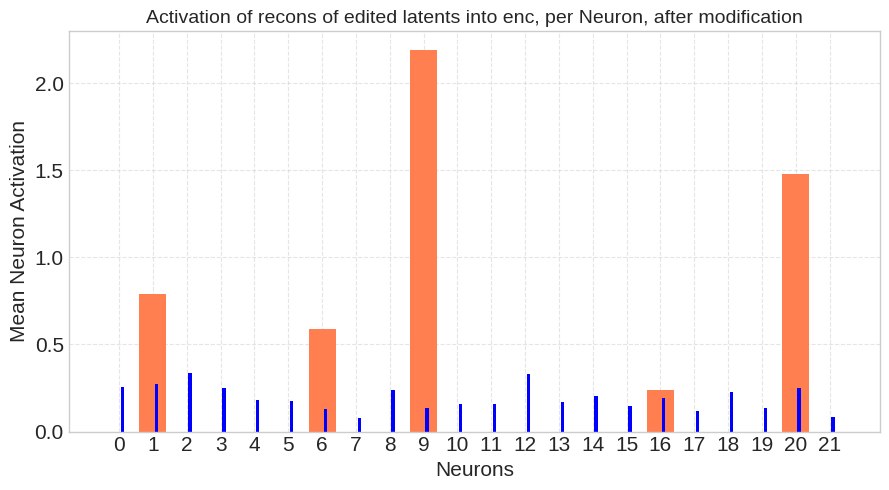

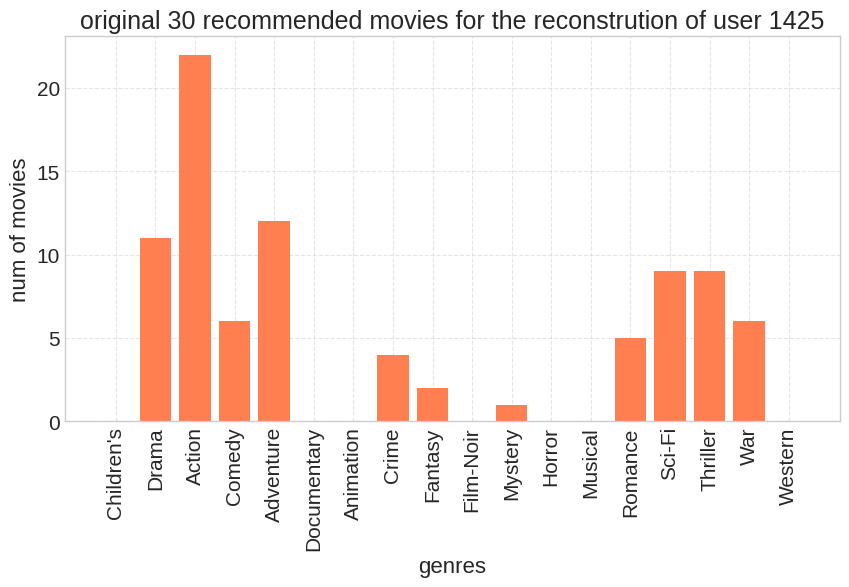

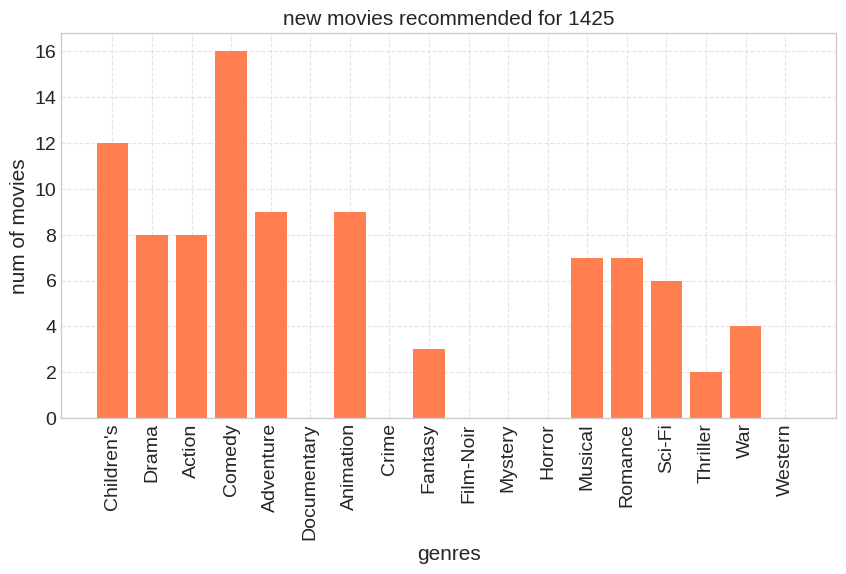


list of recommendations to the reconstruction of the modified latent representation



,movie,name,genres,pop rank
0,364,"Lion King, The (1994)","[""Children's"", 'Animation', 'Musical']",155
1,588,Aladdin (1992),"[""Children's"", 'Comedy', 'Animation', 'Musical']",96
2,1,Toy Story (1995),"[""Children's"", 'Comedy', 'Animation', 'movie_id']",29
3,595,Beauty and the Beast (1991),"[""Children's"", 'Animation', 'Musical']",182
4,3114,Toy Story 2 (1999),"[""Children's"", 'Comedy', 'Animation']",58
5,2628,Star Wars: Episode I - The Phantom Menace (1999),"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",21
6,260,Star Wars: Episode IV - A New Hope (1977),"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",1
7,2355,"Bug's Life, A (1998)","[""Children's"", 'Comedy', 'Animation']",47
8,34,Babe (1995),"[""Children's"", 'Drama', 'Comedy']",39
9,356,Forrest Gump (1994),"['Comedy', 'Romance', 'War']",25


In [ ]:
user = 1425

# dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)
latents_pre_act_all_usr, latents_all_usr, reconstructions_all_usr = autoencoder(dataset_users)

latents_numpy_array_all_usr = latents_all_usr.detach().numpy()
latents_df_all_usr = pd.DataFrame(latents_numpy_array_all_usr)
latents_df_all_usr.index = ratings_matrix.index


recons_numpy_array_all_usr = reconstructions_all_usr.detach().numpy()
recons_df_all_usr = pd.DataFrame(recons_numpy_array_all_usr)
recons_df_all_usr.index = ratings_matrix.index


# # get the relevant movie's input embeddings into the encoder
x = np.array(np.array(dataset_users[user]))
x, info = autoencoder.preprocess(x)

curr_latents = latents_all_usr[user].clone()



#-----------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(latents_df_all_usr.columns, curr_latents.detach().numpy(), color='coral')
plt.title(f'latent activation of user {user}',fontsize=17) #new user') # {user}')
plt.ylabel('Neuron Activation',fontsize=15)
plt.xlabel('Neurons',fontsize=15)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(latents_df_all_usr.columns,fontsize=15)
plt.yticks(fontsize=15)

plt.show()
#----------------------------------------------------------------------------------------------------------------------------


traget_neuron= 9
# curr_latents[neuron_one]=2
curr_latents[traget_neuron]=2.5


# get the relevant movie's output embeddings from the encoder WITH THE MODIFICATION into the decoder
# use a graph showing the encoder's output in order to understand the level of rising the relevant neuron in the modification
recons = autoencoder.decode(curr_latents,info)
_, editeEncOut_recons_latents, _ = autoencoder(np.array(recons.detach().numpy()))
df_editeEncOut_recons_latents_post_enc = pd.DataFrame(editeEncOut_recons_latents.detach().numpy())
#----------------------------------------------------------------------------------------------------------------------------


fig, (ax1) = plt.subplots(1, 1, figsize=(9, 5))

# First bar chart: Mean activation per neuron
ax1.bar(latents_df_all_usr.columns, editeEncOut_recons_latents.detach().numpy(), color='coral')
ax1.bar(latents_df_all_usr.columns+0.1, latents_all_usr.mean(axis=0).detach().numpy(), color='blue',width=0.1)

ax1.set_title(f'Activation of recons of edited latents into enc, per Neuron, after modification',fontsize=14)
ax1.set_xlabel('Neurons',fontsize=15)
ax1.set_ylabel('Mean Neuron Activation',fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(range(len(latents_df_all_usr.columns)))
ax1.set_xticklabels(latents_df_all_usr.columns,fontsize=15)
ax1.tick_params(axis='y', labelsize=15)


# Second bar chart: Mean activation normalized by standard deviation
normalized_activation = editeEncOut_recons_latents.detach().numpy() / latents_all_usr.detach().numpy().mean()



plt.tight_layout()
plt.show()


#-----------------------------------------------------------------------------------------------------------------------------
'''recommendations after modifications to the user latent representation'''
movie_num = 30

PQ_user = expit(df_b_u_emb.iloc[user,0] + pd.concat([df_b_i_emb, pd.DataFrame((pd.DataFrame(recons.detach().numpy()).T.values@(df_item_emb.T).values)).T], axis=1).sum(axis=1)) # (1, num  of movies)


top_rec_user = PQ_user.nlargest(movie_num)
# real indices because of df_item_emb
top_rec_user_id = top_rec_user.index.tolist()

# As a list of (row_idx, column_name) tuples
a_new = df_movie.iloc[top_rec_user_id,:-1].sum()
top_rec_user_id_old=  rec_gen(movie_num, user, df_b_u_emb, df_b_i_emb, df_user_emb.iloc[user,:], df_item_emb)
a = df_movie.iloc[top_rec_user_id_old,:-1].sum()


plt.figure(figsize=(10, 5))
plt.bar(all_genres, a, color='coral')
plt.title(f'original {movie_num} recommended movies for the reconstrution of user {user}',fontsize=18)
plt.ylabel('num of movies',fontsize=16)
plt.xlabel('genres',fontsize=16)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.show()


# #-----------------------------------------------------------------------------------------------------------------------------------


plt.figure(figsize=(10, 5))
plt.bar(all_genres, a_new, color='coral')
plt.title(f'new movies recommended for {user}',fontsize=15) #new user') # {user}')
plt.ylabel('num of movies',fontsize=15)
plt.xlabel('genres',fontsize=15)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)

plt.show()


# #-----------------------------------------------------------------------------------------------------------------------------------
'''recommendations for the reconstrucion of the user latent representation'''


'''list of recommendations to the reconstruction of the modified latent representation'''

print('\nlist of recommendations to the reconstruction of the modified latent representation\n')
table1_Wname = table_maker(movie_num, top_rec_user_id, df_movie, df_movie_names, num_users_per_movie_sort)

table1_Wname
#-------------------------------------------------------------------------------------------------


## Intervention-use case 2-  Nudging users toward new content

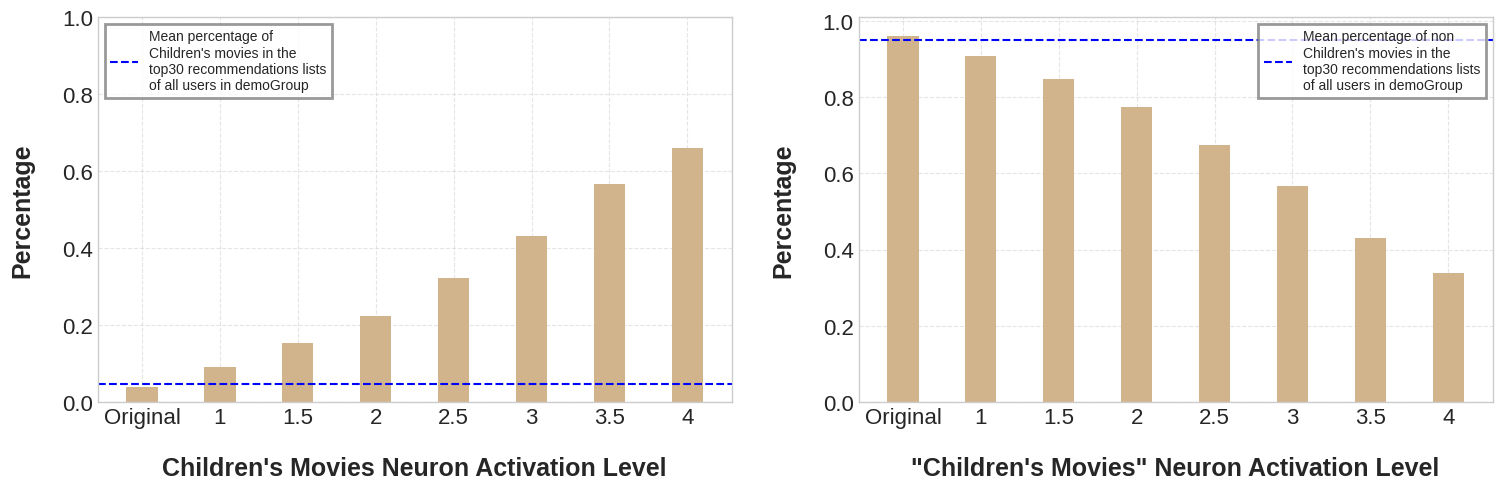

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0

target_concept = 'Children\'s'
target_neuron = 9


neuron_levels = [0.5, 1, 1.5, 2,2.5,3,3.5,4]

table = pd.DataFrame(0, index=range(len(user_group_young['user'])), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:
   no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in user_group_young['user']:


    # for original recommendations:
    PQ_user_orig = expit(df_b_u_emb.iloc[user2,0] + pd.concat([df_b_i_emb, df_user_emb.iloc[user2,:].dot(df_item_emb.T)], axis=1).sum(axis=1)) # (1, num  of movies)

    top_rec_user_orig = PQ_user_orig.nlargest(movie_num2)
    top_rec_user_id_orig = top_rec_user_orig.index.tolist()

    a_orig = df_movie.iloc[top_rec_user_id_orig,:-1].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[target_concept])/movie_num2


    orig_genres_percentage_newGenre = a_orig.loc[target_concept]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)




    # modified users:
    x2 = np.array(np.array(dataset_users[user2]))
    x2, info2 = autoencoder.preprocess(x2)
    curr_latents2 = latents_all_usr[user2].clone()
    if level != 0.5:
      curr_latents2[target_neuron]=level

    recons_user = autoencoder.decode(curr_latents2,info2)

    # generate recommendation list
    PQ_user2 = expit(df_b_u_emb.iloc[user2,0] + pd.concat([df_b_i_emb, pd.DataFrame((pd.DataFrame(recons_user.detach().numpy()).T.values@(df_item_emb.T).values)).T], axis=1).sum(axis=1)) # (1, num  of movies)

    top_rec_user2 = PQ_user2.nlargest(movie_num2)
    top_rec_user_id_new2 = top_rec_user2.index.tolist()

    a2 = df_movie.iloc[top_rec_user_id_new2,:-1].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[target_concept])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[target_concept]/movie_num2

    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)


  # each item in the list represents the averaged percentage of movies of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


neuron_levels_block = neuron_levels.copy()
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Mean percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('Children\'s Movies Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)
ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)# ax1.tick_params(axis='y', labelsize=14)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=16)# ax1.tick_params(axis='y', labelsize=14)
leg = ax1.legend([f'Mean percentage of\nChildren\'s movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)
# Access the legend frame and set its edge color and linewidth
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
ax2.bar(neuron_levels, meanOldGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax2.set_title(f'Mean percentage of non Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax2.set_xlabel('"Children\'s Movies" Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non\nChildren\'s movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)




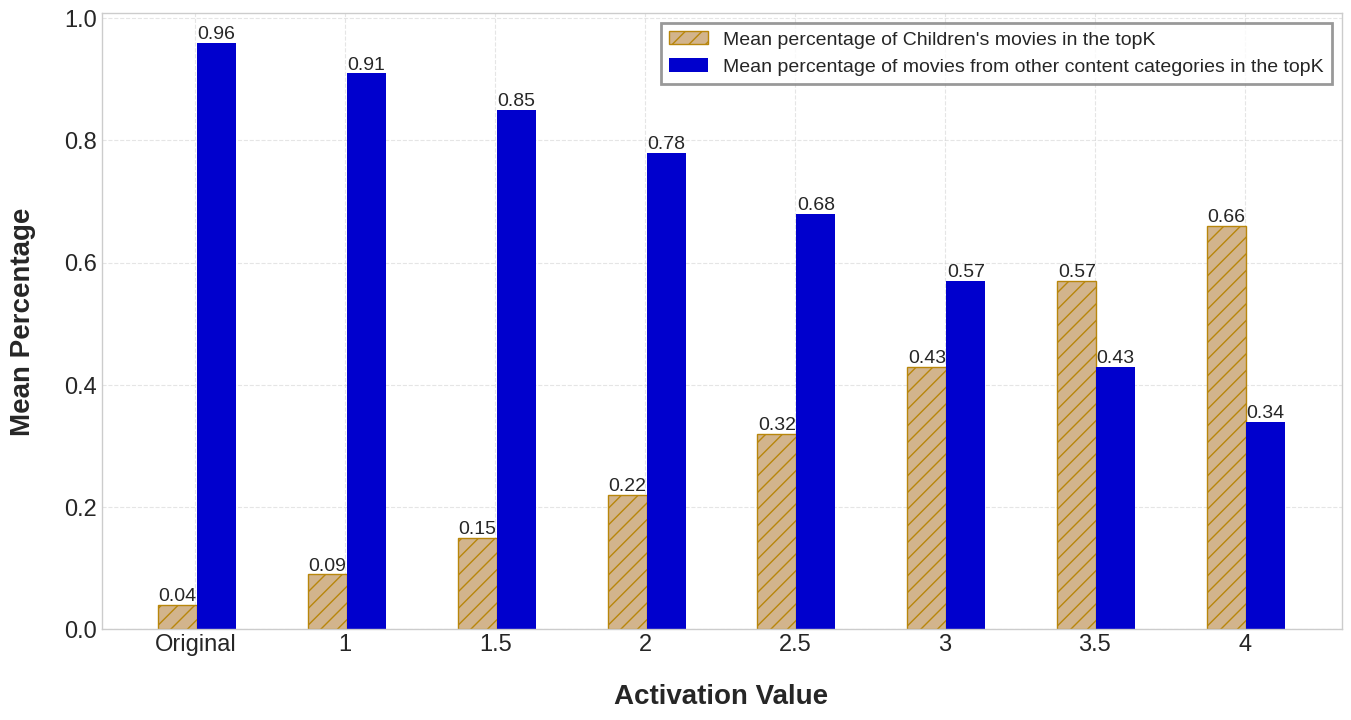

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16, 8))


# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.13, hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([0.63, 1.13, 1.63, 2.13, 2.63, 3.13, 3.63, 4.13], b, color='mediumblue', width= 0.13)
ax1.bar_label(r2,fontsize=14)

# ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
# ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Averaged percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('"Children\'s Movies" Neuron Activation Value', labelpad=20,weight='bold',fontsize=20)
ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks([0.56, 1.06, 1.56, 2.06, 2.56, 3.06, 3.56, 4.06])
# ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=17)
ax1.set_xticklabels(neuron_levels_block,fontsize=17)# ax1.tick_params(axis='y', labelsize=14)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=17)# ax1.tick_params(axis='y', labelsize=14)
leg = plt.legend([f'Mean percentage of Children\'s movies in the topK', f'Mean percentage of movies from other content categories in the topK'],frameon=True, loc='upper right', fontsize=14, fancybox=False)
# Access the legend frame and set its edge color and linewidth
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






 ## use case 3- Post hoc content suppression

generate new audience

In [ ]:
'''find the group'''
'''list of users that watched movies of certain genre, sorted by the number of
movies of the certain genre wrt the total number of movies ranked by the user'''
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

demoUsersGroup = generate_users_test_group('Horror', N, autoencoder)
demoUsersGroup

,percentage of Horror movies
3800,0.978571
1356,0.971751
1918,0.927273
5727,0.870968
1276,0.837838
5595,0.754808
304,0.745223
2701,0.731707
1930,0.709302
3997,0.700617


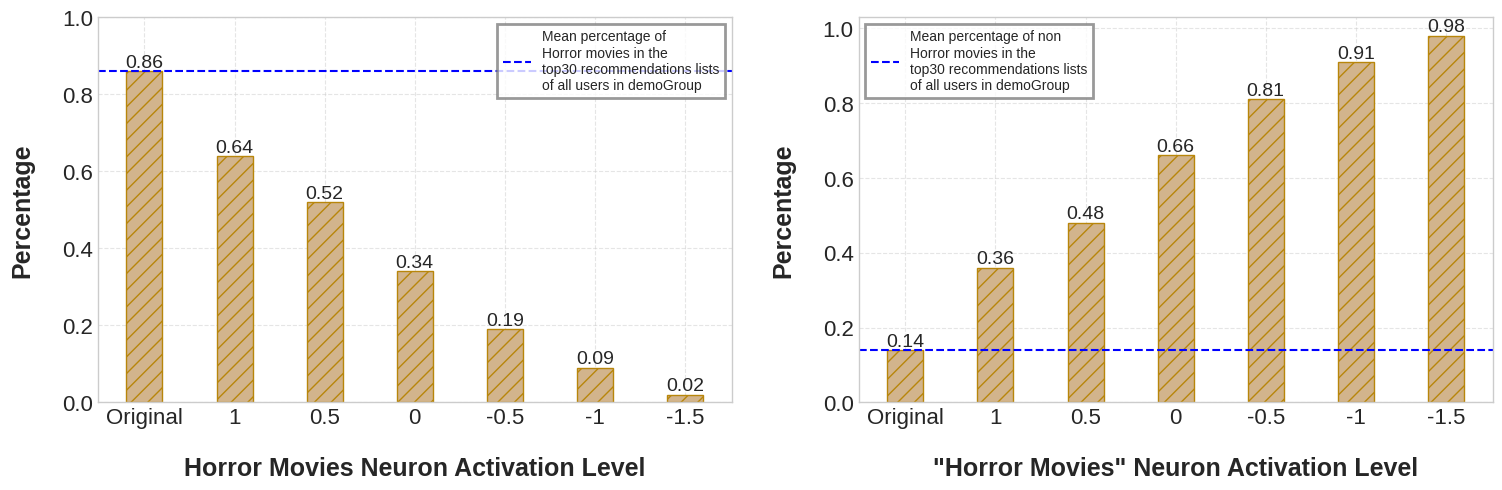

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0

target_neuron = 13
target_concept = 'Horror'


'''dealing here with orig/new results and old/new genres'''

neuron_levels = [-1.5,-1,-0.5,0,0.5,1, 1.5]


'''what place 'test_movie' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(demoUsersGroup.index)), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:

  no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in demoUsersGroup.index:


    # for original recommendations:
    PQ_user_orig = expit(df_b_u_emb.iloc[user2,0] + pd.concat([df_b_i_emb, df_user_emb.iloc[user2,:].dot(df_item_emb.T)], axis=1).sum(axis=1)) # (1, num  of movies)

    top_rec_user_orig = PQ_user_orig.nlargest(movie_num2)
    # real indices because of df_item_emb
    top_rec_user_id_orig = top_rec_user_orig.index.tolist()

    a_orig = df_movie.iloc[top_rec_user_id_orig,:-1].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[target_concept])/movie_num2

    orig_genres_percentage_newGenre = a_orig.loc[target_concept]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)



    # new/ current results: for old and new/test/curr genres:

    # modified users:
    x2 = np.array(np.array(dataset_users[user2]))
    x2, info2 = autoencoder.preprocess(x2)
    curr_latents2 = latents_all_usr[user2].clone()
    if level != -1.5:
      curr_latents2[target_neuron]=level*(-1)

    recons_user = autoencoder.decode(curr_latents2,info2)

    PQ_user2 = expit(df_b_u_emb.iloc[user2,0] + pd.concat([df_b_i_emb, pd.DataFrame((pd.DataFrame(recons_user.detach().numpy()).T.values@(df_item_emb.T).values)).T], axis=1).sum(axis=1)) # (1, num  of movies)

    top_rec_user2 = PQ_user2.nlargest(movie_num2)
    top_rec_user_id_new2 = top_rec_user2.index.tolist()
    a2 = df_movie.iloc[top_rec_user_id_new2,:-1].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[target_concept])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[target_concept]/movie_num2


    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)


  # each item in the list represents the averaged percentage of movies of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


# IF WE'RE TALKING ABOUT BLOCKIING- ADD THIS REPLACE WITH neuron_levels_names
neuron_levels_block = neuron_levels.copy()
neuron_levels_block = [item* (-1) for item in neuron_levels_block]
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.2, hatch='//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)
# ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Mean percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('Horror Movies Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)
ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=16)# ax1.tick_params(axis='y', labelsize=14)
leg = ax1.legend([f'Mean percentage of\nHorror movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax2.bar(neuron_levels, b, color='tan', width= 0.2, hatch='//', edgecolor = 'darkgoldenrod')
ax2.bar_label(r2,fontsize=14)
# ax2.bar(neuron_levels, meanOldGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax2.set_title(f'Mean percentage of non Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax2.set_xlabel('"Horror Movies" Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non\nHorror movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)
# Access the legend frame and set its edge color and
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)




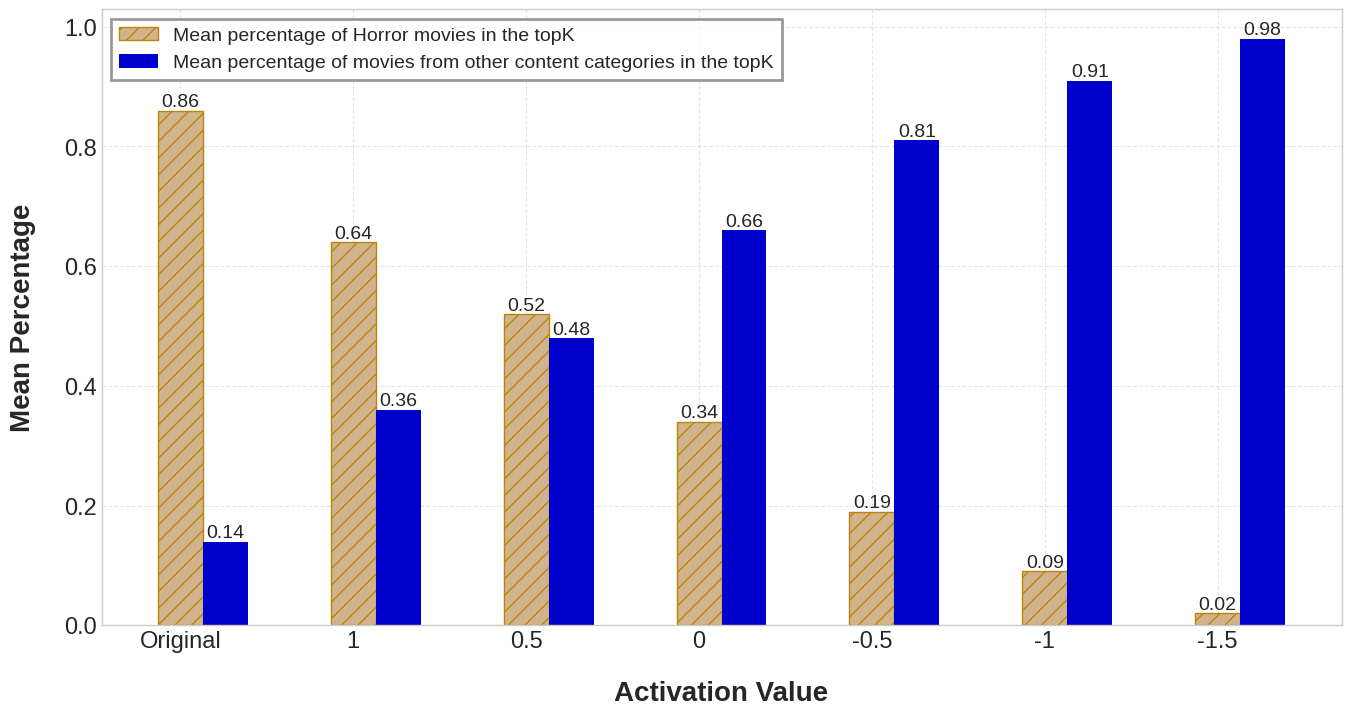

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16, 8))


# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.13, hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([-1.37,-0.87,-0.37,0.13,0.63, 1.13, 1.63], b, color='mediumblue', width= 0.13)
ax1.bar_label(r2,fontsize=14)

# ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
# ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Averaged percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('Activation Value', labelpad=20,weight='bold',fontsize=20)
ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)

# ax1.set_xticks([0.56, 1.06, 1.56, 2.06, 2.56, 3.06, 3.56, 4.06])
# ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=17)
ax1.set_xticks(neuron_levels)
ax1.set_xticklabels(neuron_levels_block,fontsize=17)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=17)# ax1.tick_params(axis='y', labelsize=14)
# leg = plt.legend([f'Mean percentage of Horror movies in the top{movie_num2}', f'Mean percentage of movies from other content categories in the top{movie_num2}'],frameon=True, loc='upper left', fontsize=14, fancybox=False)
leg = plt.legend([f'Mean percentage of Horror movies in the topK', f'Mean percentage of movies from other content categories in the topK'],frameon=True, loc='upper left', fontsize=14, fancybox=False)

frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






-

-

# SAEs' loss terms

test the rank correlation scores using RBO & Kentall Tau wrt prediction level loss term

In [ ]:
model_name_test = 'SAE_MF_loss_weight2'
# Initialize a new model instance with the same architecture
autoencoder = torch.load(Path(export_dir,f'models/other/{model_name_test}.pth'), weights_only  = False)

# test_subset = autoencoder.test_subset_ind
test_subset_users = autoencoder.test_subset_users_ind
test_subset_items = autoencoder.test_subset_items_ind


train_subset_users = [i for i in ratings_matrix.index if i not in test_subset_users]

interaction_embeddings=dataset_users[train_subset_users]


In [ ]:
with torch.no_grad():

  latents_pre_act_items, latents_items, reconstructions_items = autoencoder(dataset_item_emb)
  latents_pre_act_users, latents_users, reconstructions_users = autoencoder(dataset_user_emb)

top_rec_user_id_origs = {}
for user in autoencoder.test_subset_users_ind:
  top_rec_user_id_origs[user] = recommend_pq(user, dataset_users, dataset_items,dataset_bu,dataset_bi, 30)

latents_users=latents_users.detach().clone()
latents_items=latents_items.detach().clone()

avg_ms_score_new= ms_score_new(np.array(df_cosine_sim_matrix), latents_items)

reconstructions_users=reconstructions_users.detach().clone()
reconstructions_items=reconstructions_items.detach().clone()



users_ind= autoencoder.test_subset_users_ind

lists_compare_table = pd.DataFrame(0, index=users_ind, columns=['RBO Score', 'Kendall Tau Score'])

for user in lists_compare_table.index:

top_rec_user_id_rec  = recommend_pq(user, reconstructions_users, reconstructions_items,dataset_bu,dataset_bi, 30)   
lists_compare_table.loc[user,'RBO Score'] = rbo(top_rec_user_id_origs[user], top_rec_user_id_rec)
lists_compare_table.loc[user,'Kendall Tau Score'] = kendall_tau(top_rec_user_id_origs[user], top_rec_user_id_rec)

print(f'{round(float(lists_compare_table.mean().iloc[0]),6)} | {round(float(lists_compare_table.mean().iloc[1]),6)}')
print(f'averaged new MS score: {avg_ms_score_new}')
